# Maximum Flow solution for optimal FX trading
## Introduction
**Problem:**
We have the following recursive relation for the amount of units $f_i^t$ for the $i$th currency in the portfolio at time $t$:  
\begin{cases} 
f_1^0 = 1; \ f_i^0 = 0, \ i=2 \dots n \\ 
f_i^t=\sum_{j=1}^{n} f_j^{t-1}w_{ji}^tr_{ji}^t, \ t=1 \dots T \\ 
\end{cases}  

The problem is to:  
$\max \ f_1^T$  

Subject to the constraints:  
$\sum_{i=1}^{n} w_{ji}^t=1, \ t=1 \dots T, \ j=1 \dots n$  


## Preparation for the code run
First, take a moment and download all of the necessary packages to perform optimisation. This includes: **tensorflow** and **cvxopt**

In [1]:
conda install -c ibmdecisionoptimization cplex

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install -c conda-forge cvxopt

Solving environment: done

## Package Plan ##

  environment location: /Users/katarinapetrovic/opt/anaconda3

  added / updated specs:
    - cvxopt


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cvxopt-1.2.0               |   py37hde55871_0         444 KB
    ------------------------------------------------------------
                                           Total:         444 KB

The following packages will be DOWNGRADED:

  cvxopt                               1.2.0-py37hcab12e0_0 --> 1.2.0-py37hde55871_0



cvxopt-1.2.0         | 444 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.12.0-py3-none-any.whl

  Using cached https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.12.0-py3-none-any.whl (62.0 MB)
You should consider upgrading via the '/Users/katarinapetrovic/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install statsmodels --upgrade

  Using cached statsmodels-0.12.2-cp37-cp37m-macosx_10_15_x86_64.whl (9.5 MB)
     |████████████████████████████████| 9.6 MB 2.9 MB/s eta 0:00:01
You should consider upgrading via the '/Users/katarinapetrovic/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Include all the necessary libraries 

In [1]:
import pandas as pd
import random
import numpy as np
from sklearn import linear_model
import scipy as sp
import time
import cvxopt
import matplotlib.pyplot as plt
import networkx as nx
from dateutil import parser
from pandas.plotting import lag_plot
import oandapyV20
from oandapyV20.exceptions import V20Error
import oandapyV20.endpoints.instruments as instruments
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
import scipy.stats
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
client = oandapyV20.API(access_token="d4902ea675170b9f8506b2967e8c6f22-10aaf3f544a24aa91c6de6fec7ba293c")

In [2]:
# Helper functions for csv:

# Read csv and return pandas df.
# Input: path, path of csv. This csv should have first column as timestamps; 
#        columns: list, if unspecified then will use the first row of csv, otherwise assume no header in csv and use columns as the columns of the returned df
#        usecols: list of str, columns that would like to be read.
# Output: pandas df, with columns as columns and first column as index
def read_csv(path, columns = 0, usecols = None):
    if columns != 0:
        if usecols is not None:
            return pd.read_csv(path, names=columns, header=None, parse_dates=[0], index_col = 0, usecols=[columns[0]] + usecols)
        return pd.read_csv(path, names=columns, header=None, parse_dates=[0], index_col = 0)
    if usecols is not None:
        return pd.read_csv(path, header = columns, parse_dates=[0], index_col = 0, usecols=[columns[0]] + usecols)
    return pd.read_csv(path, header = columns, parse_dates=[0], index_col = 0)

# Write csv to path.
def to_csv(path, df):
    df.to_csv(path)

# Class of currency history price. Each instance represents a currency pair 'XXX_YYY' with its history bid, ask price
class Curncy_Hist_PX:
    
    # Keeps track of created instances in this subclass
    fx_list = []
    inst_dict = {}
    
    # Instance init function. Get price data and creates instance of currency pair history price.
    # Inputs: base_curncy: str of base currency in form 'XXX'; quote_curncy: str of quote currency in form 'YYY'
    # Outputs: None
    # Attributes: name: str, in form 'XXX_YYY'; 
    #             bid_px, ask_px: all np array;
    #             px_time: np array, timestamps corresponding to the above prices
    # Needs to be modified if one would like to change the data source.
    def __init__(self, base_curncy, quote_curncy):
        
        curncy_name = '_'.join([base_curncy,quote_curncy])
        
        # Case: base_curncy == quote_curncy. No query, all rates are 1.
        if base_curncy == quote_curncy:
            self.name = curncy_name
            _, _, self.px_time = self.get_hist_px('EUR_USD')
            self.bid_px = np.ones(np.shape(self.px_time)[0])
            self.ask_px = np.ones(np.shape(self.px_time)[0])
            if base_curncy not in Curncy_Hist_PX.fx_list: Curncy_Hist_PX.fx_list.append(base_curncy)
            Curncy_Hist_PX.inst_dict[curncy_name] = {'Base': base_curncy, 'Quote': quote_curncy, 'Object': self}
            
        else:
            # Case: can query product 'base_curncy'_'quote_curncy'
            try:
                self.name = curncy_name
                self.bid_px, self.ask_px, self.px_time = self.get_hist_px(self.name)
                if base_curncy not in Curncy_Hist_PX.fx_list: Curncy_Hist_PX.fx_list.append(base_curncy)
                if quote_curncy not in Curncy_Hist_PX.fx_list: Curncy_Hist_PX.fx_list.append(quote_curncy)
                Curncy_Hist_PX.inst_dict[curncy_name] = {'Base': base_curncy, 'Quote': quote_curncy, 'Object': self}
                print("Got {curncy} price using {curncy}".format(curncy=self.name))
                
            except (V20Error, KeyError):
                # Case: can query the reverse product 'quote_curncy'_'base_curncy'. Bid and ask prices are switched and then taken the inverse. 
                # Example: 'JPY_USD' may not be an existing product in many data sources, since the prices are too small.
                #          However it is possible to query from 'USD_JPY', which is equivalent up to switching bid and ask prices. 
                try:
                    self.name = curncy_name
                    rev_name = '_'.join([quote_curncy,base_curncy])
                    rev_bid_px, rev_ask_px, self.px_time = self.get_hist_px(rev_name)
                    self.bid_px = 1./rev_ask_px
                    self.ask_px = 1./rev_bid_px
                    if base_curncy not in Curncy_Hist_PX.fx_list: Curncy_Hist_PX.fx_list.append(base_curncy) 
                    if quote_curncy not in Curncy_Hist_PX.fx_list: Curncy_Hist_PX.fx_list.append(quote_curncy)
                    Curncy_Hist_PX.inst_dict[curncy_name] = {'Base': base_curncy, 'Quote': quote_curncy, 'Object': self}
                    print("Got {curncy} price using {rev_curncy}".format(curncy=curncy_name,rev_curncy=rev_name))

                except:
                    raise ValueError("Was not able to get price for {curncy}".format(curncy=curncy_name))
    
    # The following methods are high level query methods. Do not need to be changed if need to change data source.
    
    # Returns the instance of a pair by its base_curncy name and quote_curncy name. If it does not exist, create it.
    # Inputs: base_curncy: str of base currency in form 'XXX'; quote_curncy: str of quote currency in form 'YYY'
    # Outputs: class instance
    @classmethod
    def query(cls, base_curncy, quote_curncy):
        inst_name = '_'.join([base_curncy,quote_curncy])
        if inst_name in cls.inst_dict:
            return cls.inst_dict[inst_name]['Object']
        else:
            return cls(base_curncy, quote_curncy)
    
    # Query bid price of a pair as np array by its base_curncy name and quote_curncy name
    # Inputs: base_curncy: str of base currency in form 'XXX'; quote_curncy: str of quote currency in form 'YYY'
    # Outputs: pandas df, size: (num_timestamps, 1), data: prices, index: the timestamps corresponding to the prices, columns: instrument name, ie 'base_curncy'_'quote_curncy'.
    @classmethod
    def query_bid_as_df(cls, base_curncy, quote_curncy):
        inst_name = '_'.join([base_curncy,quote_curncy])
        inst_object = cls.query(base_curncy, quote_curncy)
        bid_px_df = pd.DataFrame(data=inst_object.bid_px, index=inst_object.px_time,columns=[inst_name])
        bid_px_df_copy = bid_px_df.copy()
        return bid_px_df_copy
    
    # Query all bid prices between all recorded single currency as df.
    # Example: If we have previously only created instances of 'EUR_USD' and 'GBP_JPY', this function will return 16 prices between 'EUR', 'USD', 'GBP', 'JPY'
    # For instance, if curncy_list = ['USD', 'EUR'], then the column names of fx_px_df should be ['USD_USD', 'USD_EUR', 'EUR_USD', 'EUR_EUR'].
    # Inputs: time_steps: int, if provided, then will only return the latest time_steps prices. csv_path: if provided, will write a csv file at path. 
    # Outputs: pandas df, size: (num_timestamps, num_curncy_pairs), data: prices, index: the timestamps corresponding to the prices, columns: list of all instrument names, ie all 'base_curncy'_'quote_curncy'.
    @classmethod
    def query_database_as_df(cls, time_steps=None, csv_path = None):
        master_df = pd.DataFrame()
        for curncy_1 in cls.fx_list:
            for curncy_2 in cls.fx_list:
                df = cls.query_bid_as_df(curncy_1,curncy_2)
                master_df = master_df.join(df,how='outer',sort=True)
        master_df.dropna(axis=0,inplace=True)
        if time_steps:
            if csv_path:
                to_csv(csv_path, master_df[-time_steps:])
            return master_df[-time_steps:]
        else:
            if csv_path:
                to_csv(csv_path, master_df)
            return master_df
    
    # Only query USD_XXX as df.
    # Example: If we have previously only created instances of 'EUR_USD' and 'GBP_JPY', this function will return 4 prices between 'USD' and 'EUR', 'USD', 'GBP', 'JPY'
    # Inputs: time_steps: int, if provided, then will only return the latest time_steps prices. csv_path: if provided, will write a csv file at path.
    # Outputs: pandas df, size: (num_timestamps, num_curncy), data: prices, index: the timestamps corresponding to the prices, columns: list of all instrument names, ie all 'USD'_'quote_curncy'.
    @classmethod
    def query_database_usd_px_as_df(cls, time_steps=None, csv_path = None):
        master_df = pd.DataFrame()
        for curncy_2 in cls.fx_list:
            df = cls.query_bid_as_df('USD',curncy_2)
            master_df = master_df.join(df,how='outer',sort=True)
        master_df.dropna(axis=0,inplace=True)
        if time_steps:
            if csv_path:
                to_csv(csv_path + '_USD_Only', master_df[-time_steps:])
            return master_df[-time_steps:]
        else:
            if csv_path:
                to_csv(csv_path + '_USD_Only', master_df)
            return master_df
    
    # Query all bid prices with commission as df.
    # Example: If we have previously only created instances of 'EUR_USD' and 'GBP_JPY', this function will return 16 prices with commission between 'EUR', 'USD', 'GBP', 'JPY'
    # For instance, if curncy_list = ['USD', 'EUR'], then the column names of fx_px_df should be ['USD_USD', 'USD_EUR', 'EUR_USD', 'EUR_EUR'].
    # Inputs: time_steps: int, if provided, then will only return the latest time_steps prices; commission: float, amount of commission, all bid prices are multiplied by (1 - commission). csv_path: if provided, will write a csv file at path.
    # Outputs: pandas df, size: (num_timestamps, num_curncy_pairs), data: prices with commission, index: the timestamps corresponding to the prices, columns: list of all instrument names, ie all 'base_curncy'_'quote_curncy'.
    @classmethod
    def query_database_as_df_with_commission(cls, time_steps=None, commission=0, csv_path = None):
        master_df = pd.DataFrame()
        for curncy_1 in cls.fx_list:
            for curncy_2 in cls.fx_list:
                df = cls.query_bid_as_df(curncy_1,curncy_2)
                if curncy_1 != curncy_2:
                    df[:] *= (1 - commission)
                master_df = master_df.join(df,how='outer',sort=True)
        master_df.dropna(axis=0,inplace=True)
        if time_steps:
            if csv_path:
                to_csv(csv_path + '_with_' + str(commission) + '_Commission', master_df[-time_steps:])
            return master_df[-time_steps:]
        else:
            if csv_path:
                to_csv(csv_path + '_with_' + str(commission) + '_Commission', master_df)
            return master_df

# Subclass: to get price from Oanda (Can only use one subclass) 
class Oanda_Hist_PX(Curncy_Hist_PX):
    
    # Parameters for Oanda API. 
    params = {
    "price": "MBA",    
    "granularity": "D",
    "count": 500
    }
    
    # Low level function to get price for a particular pair from OANDA. Only use in the class init function. 
    # Inputs: fx_name: str, in form 'XXX_YYY'
    # Outputs: bid_px, ask_px: np array;
    #          px_time: np array, timestamps corresponding to the above prices
    @classmethod
    def get_hist_px(cls, fx_name):
        r = instruments.InstrumentsCandles(instrument=fx_name, params=cls.params)
        client.request(r)
        px_time = pd.to_datetime(np.array([parser.parse(candle["time"]) for candle in r.response["candles"]]))
        bid_px = np.array([float(candle["bid"]["c"]) for candle in r.response["candles"]])
        ask_px = np.array([float(candle["ask"]["c"]) for candle in r.response["candles"]])
        return bid_px, ask_px, px_time

# Subclass: to get price from Csv (Can only use one subclass) 
class Csv_Hist_PX(Curncy_Hist_PX):
    
    # Parameters for the csv file. Columns: list of str, if unspecified (0) then assume the csv file has the correct column headings in the first row, else specify the column headings in this format: 'XXX_YYY_bid' or 'XXX_YYY_ask'.
    params = {
    "columns": 0,    
    "csv_path": "",
    "usecols" : None
    }
    
    # Low level function to get price for a particular pair from a csv. Only use in the class init function. 
    # Inputs: fx_name: str, in form 'XXX_YYY';
    #         path: path of csv file, the first column should be the timestamps of the prices;
    # Outputs: bid_px, ask_px: np array;
    #          px_time: np array, timestamps corresponding to the above prices
    @classmethod
    def get_hist_px(cls, fx_name):
        df = read_csv(cls.params["csv_path"], columns = cls.params["columns"], usecols=cls.params["usecols"])
        px_time = df.index.to_numpy()
        bid_px = df[fx_name + '_bid'].to_numpy()
        ask_px = df[fx_name + '_ask'].to_numpy()
        return bid_px, ask_px, px_time

In [3]:
# Helper functions

# Create a list of all currency pairs from base_curncy_list (and quote_curncy_list).
# Inputs: base_curncy_str_list: list of str, list of currency names in form 'XXX';
#         quote_curncy_str_list: if provided, list of str, list of currency names in form 'YYY';
# Outputs: list of str in form 'XXX_YYY', all combinations between entries in base_curncy_str_list, 
#          or base_curncy_str_list and quote_curncy_str_list, if the latter is provided.
def fx_pair_str(base_curncy_str_list, quote_curncy_str_list = None):
    if quote_curncy_str_list is None :
        quote_curncy_str_list = base_curncy_str_list
    fx_pair_str_list = []
    for base_curncy in base_curncy_str_list:
        for quote_curncy in quote_curncy_str_list:
            fx_pair_str_list.append("_".join([base_curncy,quote_curncy]))
    return fx_pair_str_list

# Calculates the day to day log returns
# Inputs: pandas df, size (num_timestamps, num_curncy_pairs), data: prices, index: timestamps corresponding to prices, columns: list of all instrument names
# Outputs: pandas df, size (num_timestamps-1, num_curncy_pairs), data: daily log returns, index: timestamps[1:], columns: list of all instrument names
def log_return(fx_px): 
    fx_px_array = fx_px.to_numpy()
    log_return_mtrx = np.log(fx_px_array[1:,:]/fx_px_array[:-1,:])
    return pd.DataFrame(data=log_return_mtrx,index=fx_px.index[1:],columns=fx_px.columns)

# Calculates the Multiple Correlation (squared) between one variable and a set of other variables.
# It is the same as calculating the R^2 score using the predictor_vars to regress the target_var.
# The higher the score, the higher the multiple correlation. In the case of FX, it means that one instrument is more similar to a linear combination of others. 
# Inputs: predictor_vars: np array, size: (num_timestamps, num_variables), each column is a explanatory variable; 
#         target_var: np array, size: (num_timestamps, 1), response variable;
# Outputs: float, R^2 score of the linear regression model using the predictor_vars to regress the target_var
def multi_corr(predictor_vars,target_var): #inputs a (T,n) sized np array of predictors and a (T,1) sized target
    reg = linear_model.LinearRegression(fit_intercept=False).fit(predictor_vars, target_var)
    return reg.score(predictor_vars, target_var)

# Finds least correlated FX pairs in the sense of Least Multiple Correlation
# Inputs: fx_rts: pandas df, size: (num_timestamps, num_curncy_pairs), data: each column is the returns of an instrument, with the first one as base currency that will always be selected, index: timestamps corresponding to the returns, columns: list of the instruments names;
#         num_pairs: int, how many least correlated FX pairs to find
# Outputs: pandas df, size: (num_timestamps, num_used_curncy_pairs), keeps the columns of fx_rts that are selected with the rest discarded.
def least_corr_pair(fx_rts, num_pairs): 
    fx_rts_array = fx_rts.to_numpy()
    num_fxs = np.shape(fx_rts_array)[1]
    num_remain = num_fxs
    used_fx_rt_list = fx_rts_array[:,0].reshape(-1,1)
    used_fx_idx = [0]
    num_pairs -= 1
    num_remain -= 1
    while min(num_remain,num_pairs) > 0:
        scores = []
        for j in range(num_fxs):
            if j in used_fx_idx:
                scores.append(2)
            else:
                scores.append(multi_corr(used_fx_rt_list,fx_rts_array[:,j]))
        min_idx = np.argmin(scores)
        used_fx_idx.append(min_idx)
        used_fx_rt_list = np.concatenate((used_fx_rt_list,fx_rts_array[:,min_idx].reshape(-1,1)),axis=1)
        # np.delete(fx_rts,min_idx,1)
        num_pairs -= 1
        num_remain -= 1
    return pd.DataFrame(data=used_fx_rt_list, index=fx_rts.index, columns=fx_rts.columns[used_fx_idx])

# Returns a weighted incidence matrix of the directed graph from fx_px_df
# Inputs: fx_px_df: pandas df, size: (num_timestamps, num_curncy_pairs), data: each column is the price of a currency pair, index: timestamps corresponding to the returns, columns: list of the instruments names in form 'XXX_YYY';
#         curncy_list: list of str, list of currency names in form 'XXX';
#         ! Note !: The column names of fx_px_df should be exactly all combinations of str in curncy_list in form of 'XXX_YYY' in specific order. For instance, if curncy_list = ['USD', 'EUR'], then the column names of fx_px_df should be ['USD_USD', 'USD_EUR', 'EUR_USD', 'EUR_EUR'].
# Outputs: pandas df, size: (num_curncy*(num_timestamps+1), num_curncy*(num_timestamps+1)), data: the weighted incidence matrix of the directed graph, index and columns: curncy_list appended with each timestep
#          For example, using previous example, if there are 2 prices / rows in fx_px_df, then the output will be of size 6*6, with the index and column names equal to ['USD_0', 'EUR_0', 'USD_1', 'EUR_1', 'USD_2', 'EUR_2'], representing each node of each currency at each step. Since we require an initial node, the indexing starts at 0 to 2. The data of the matrix represents the weighted incidence matrix, with weights as in fx_px_df. If weight is 0, then it means that there's no path. 
def fx_px_to_graph(fx_px_df, curncy_list):
    fx_px_array = fx_px_df.to_numpy()
    num_timesteps, num_pairs = fx_px_array.shape
    num_curncy = len(curncy_list)
    fx_graph_mtrx = np.eye(num_curncy*(num_timesteps+1), k=num_curncy)
    for t in range(num_timesteps):
        fx_graph_mtrx[t*num_curncy:(t+1)*num_curncy,(t+1)*num_curncy:(t+2)*num_curncy] = fx_px_array[t,:].\
            reshape((num_curncy,num_curncy))
    idx_n_header = []
    for t in range(num_timesteps+1):
        for curncy in curncy_list:
            idx_n_header.append(curncy + '_' + str(t))
    return pd.DataFrame(data=fx_graph_mtrx,index=idx_n_header,columns=idx_n_header)

# Used for Scipy function shortest_path's predecessors output. Converts predecessors matrix back to a series of currency indexes in the path at each step.
# Inputs: predecessor_mtrx: numpy array, size: (num_nodes, num_nodes), output from scipy function: https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.sparse.csgraph.shortest_path.html
#         num_timesteps: int, number of timesteps;
#         num_curncy: int, number of currencies.
# Outputs: list, length: num_timesteps, traces back the path from node 0 ('USD_0') to node num_timesteps*num_curncy ('USD_num_timesteps') and returns the intermediate node indexes.
# The node indexes are labeled in order 'USD_0', 'EUR_0', 'USD_1', 'EUR_1', 'USD_2', 'EUR_2' from 0 to 5 in previous example.
def predecessor_to_list(predecessor_mtrx,num_timesteps,num_curncy):
    col_loc = num_timesteps*num_curncy
    idx_list = [col_loc]
    while col_loc > 0:
        idx_list.append(predecessor_mtrx[0,col_loc])
        col_loc = predecessor_mtrx[0,col_loc]
    idx_list = idx_list[::-1]
    return idx_list

# Converts list of currency node indexes into currency names to hold at each step and return df with indexes as the dates of the timesteps. 
# Inputs: idx_list: defined as in output of predecessor_to_list.
#         num_curncy: int, number of currencies.
#         fx_px_time: the timestamps corresponding to the prices in queried price df;
#         curncy_list: list of str, list of currency names in form 'XXX';
# Outputs: pandas df, index: 'Start' label + fx_px_time, data: the path of currencies in form 'XXX'.
def idx_to_curncy(idx_list,num_curncy,fx_px_time,curncy_list):
    idx_list = [idx % num_curncy for idx in idx_list]
    fx_path = np.array(curncy_list)[idx_list]
    fx_px_time = fx_px_time.insert(0, 'Start')
    return pd.DataFrame(data=fx_path,index=fx_px_time)

# Plot the fx problem digraph with solved optimal path
# Inputs: fx_graph_mtrx: pandas df, data: weighted incidence matrix with weights as rates of prices / costs. Format should be the same as the output of fx_px_to_graph.
#         weight_graph_mtrx: pandas df, data: weighted incidence matrix with weights as the proportion of allocations. Format should be the same as the output of fx_px_to_graph.
#         num_curncy: int, number of currencies;
#         num_timesteps: int, number of timesteps;
#         disp_rate: Whether in labels rate should be displayed;
#         disp_weight: Whether in labels weight should be displayed;
#         disp_all_label: bool, whether all the labels should be displayed. If false, only edge labels of edges with meaningfully large weights will be displayed.  
# Outputs: None.
# Could use this on any spatio-temporal-graphs.
def plot_fx_digraph(fx_graph_mtrx, weight_graph_mtrx, num_curncy, num_timesteps, disp_rate = True, disp_weight = True, disp_all_label = False):
    plt.figure(figsize=(num_curncy*3,num_timesteps*3))
    G = nx.from_numpy_matrix(fx_graph_mtrx.to_numpy(),create_using=nx.DiGraph())
    pos = {name: (i%num_curncy, i//num_curncy) for i, name in enumerate(fx_graph_mtrx.columns.to_list())}
    G = nx.relabel_nodes(G, dict(enumerate(fx_graph_mtrx.columns)))
    nx.draw_networkx_nodes(G, pos, with_labels = True, node_color='w')
    for edge in G.edges:
        nx.draw_networkx_edges(G, pos, edgelist=[edge], arrowstyle='->',
                                   arrowsize=10, width=2, alpha=min((weight_graph_mtrx.loc[edge]+0.2),1))
        if disp_rate is True and disp_weight is True:
            label = 'Rate: ' + format(G[edge[0]][edge[1]]['weight'], '.5f') + '\n Weight: ' + format(weight_graph_mtrx.loc[edge], '.2f')
        else:
            label = ''
            if disp_rate is True:
                label += 'Rate: ' + format(G[edge[0]][edge[1]]['weight'], '.5f')
            if disp_weight is True:
                label += 'Weight: ' + format(weight_graph_mtrx.loc[edge], '.2f')
        if abs(weight_graph_mtrx.loc[edge]) >= 10**(-8): 
            nx.draw_networkx_edge_labels(G,pos,label_pos=0.65,edge_labels={edge: label},
                                     alpha=min((weight_graph_mtrx.loc[edge]+0.2),1), font_size=10)
        elif disp_all_label is True:
            nx.draw_networkx_edge_labels(G,pos,label_pos=0.65,edge_labels={edge: 'Rate: ' + format(G[edge[0]][edge[1]]['weight'], '.5f') + '\n Weight: ' + format(weight_graph_mtrx.loc[edge], '.2f')},
                                     alpha=min((weight_graph_mtrx.loc[edge]+0.2),1), font_size=10)
    nx.draw_networkx_labels(G, pos)
    plt.show()

# Plot any directed graph from graph_incidence_mtrx.
# Could try to change pos = nx.shell_layout(G) for other layouts. Do manually like above or see https://networkx.github.io/documentation/stable/reference/drawing.html#module-networkx.drawing.layout
def plot_graph(graph_incidence_mtrx, weight_graph_mtrx = None, disp_rate = True, disp_weight = True, disp_all_label = True):
    plt.figure(figsize=graph_incidence_mtrx.shape)
    G = nx.from_numpy_matrix(graph_incidence_mtrx.to_numpy(),create_using=nx.DiGraph())
    G = nx.relabel_nodes(G, dict(enumerate(graph_incidence_mtrx.columns)))
    pos = nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos, with_labels = True, node_color='w')
    for edge in G.edges:
        nx.draw_networkx_edges(G, pos, edgelist=[edge], arrowstyle='->',
                                   arrowsize=10, width=2, alpha=min((weight_graph_mtrx.loc[edge]+0.2),1))
        if disp_rate is True and disp_weight is True:
            label = 'Rate: ' + format(G[edge[0]][edge[1]]['weight'], '.5f') + '\n Weight: ' + format(weight_graph_mtrx.loc[edge], '.2f')
        else:
            label = ''
            if disp_rate is True:
                label += 'Rate: ' + format(G[edge[0]][edge[1]]['weight'], '.5f')
            if disp_weight is True:
                label += 'Weight: ' + format(weight_graph_mtrx.loc[edge], '.2f')
        if abs(weight_graph_mtrx.loc[edge]) >= 10**(-8): 
            nx.draw_networkx_edge_labels(G, pos, label_pos=0.65,edge_labels={edge: label},
                                     alpha=min((weight_graph_mtrx.loc[edge]+0.2),1), font_size=10)
        elif disp_all_label is True:
            nx.draw_networkx_edge_labels(G, pos, label_pos=0.65,edge_labels={edge: 'Rate: ' + format(G[edge[0]][edge[1]]['weight'], '.5f') + '\n Weight: ' + format(weight_graph_mtrx.loc[edge], '.2f')},
                                     alpha=min((weight_graph_mtrx.loc[edge]+0.2),1), font_size=10)
    nx.draw_networkx_labels(G, pos)
    plt.show()

In [4]:
# Get price histories
Oanda_Hist_PX.params["count"] = 500
Oanda_Hist_PX.params["granularity"] = 'D'

curncy_list = ['USD','EUR','JPY']
num_curncy = len(curncy_list)

for curncy in curncy_list:
    Oanda_Hist_PX(curncy,curncy)

# Calculates num_least_corr_pairs least correlated pairs in the sense of Multiple Correlation.
fx_px_df = Oanda_Hist_PX.query_database_as_df()
fx_rt_df = log_return(fx_px_df)
num_least_corr_pairs = 1
least_corr_fx_rt_df = least_corr_pair(fx_rt_df.iloc[:,1:],num_least_corr_pairs)
least_corr_fx_corr = np.corrcoef(least_corr_fx_rt_df.to_numpy(), rowvar=False)
least_corr_fx_corr_df = pd.DataFrame(data=least_corr_fx_corr, index=least_corr_fx_rt_df.columns, 
                                     columns=least_corr_fx_rt_df.columns)

print("{num_least_corr_pairs} least correlated pairs: {least_corr_curncy_list}".format(
    num_least_corr_pairs=num_least_corr_pairs,least_corr_curncy_list=least_corr_fx_rt_df.columns))

Got USD_EUR price using EUR_USD
Got USD_JPY price using USD_JPY
Got EUR_USD price using EUR_USD
Got EUR_JPY price using EUR_JPY
Got JPY_USD price using USD_JPY
Got JPY_EUR price using EUR_JPY
1 least correlated pairs: Index(['USD_EUR'], dtype='object')


In [5]:
# Set up problem with commissions
commission = 0.0
num_timesteps = 487
fx_px_df = Oanda_Hist_PX.query_database_as_df_with_commission(time_steps=num_timesteps,commission=commission)
fx_px = fx_px_df.to_numpy()
fx_px_time = fx_px_df.index
num_timesteps = fx_px.shape[0]

#Print scale of problem.
print("The current scale of problem is: {num_curncy} currencies, {num_timesteps} timesteps.".format(
    num_curncy=num_curncy, num_timesteps=num_timesteps))

The current scale of problem is: 3 currencies, 487 timesteps.


## Forecasting exchange rates using an ARIMA model
$y(t+1) = b_{0}+b_{1}y(t)$

In [6]:
fx_px_df.columns

Index(['USD_USD', 'USD_EUR', 'USD_JPY', 'EUR_USD', 'EUR_EUR', 'EUR_JPY',
       'JPY_USD', 'JPY_EUR', 'JPY_JPY'],
      dtype='object')

In [8]:
usd_eur_df = fx_px_df.iloc[:,1]
usd_jpy_df = fx_px_df.iloc[:,3]
#usd_chf_df = fx_px_df.iloc[:,4]
#usd_aud_df = fx_px_df.iloc[:,2]

## Examining the time series signal 

Text(0.5, 1.0, 'USD/EUR Trend')

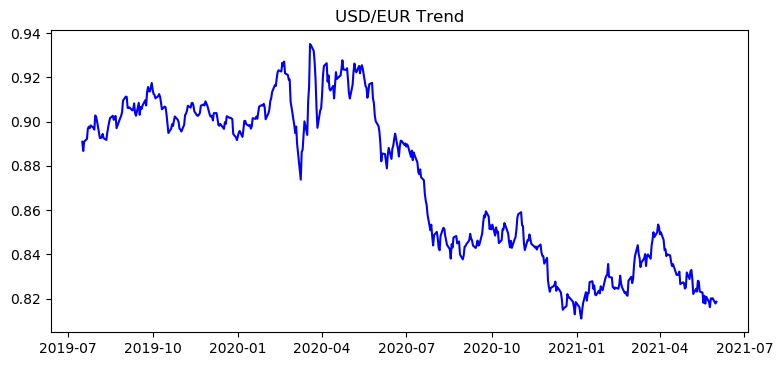

In [11]:
plt.figure(figsize=(9,4), dpi=100)
plt.plot(usd_eur_df, color = 'b')
plt.title('USD/EUR Trend')

In [9]:
X = stat.values
split = round(len(X) / 5)
X1, X2, X3, X4, X5 = X[0:split], X[split:2*split], X[2*split:3*split], X[3*split:4*split], X[4*split:]
mean1, mean2, mean3, mean4, mean5 = X1.mean(), X2.mean(),X3.mean(),X4.mean(),X5.mean()
var1, var2, var3, var4, var5 = X1.var(), X2.var(), X3.var(),X4.var(),X5.var()
mean = np.array([mean1, mean2, mean3, mean4, mean5])
var = [var1, var2, var3, var4, var5]

NameError: name 'stat' is not defined

In [10]:
x= [1,2,3,4,5]
plt.plot(mean, color = 'b', marker='.')
plt.title('Mean(t)')

NameError: name 'mean' is not defined

Text(0.5, 1.0, 'Variance(t)')

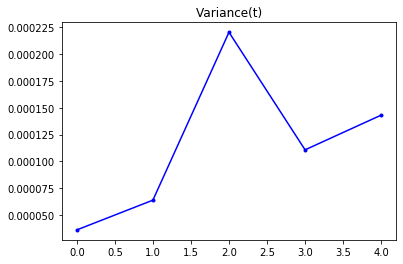

In [52]:
plt.plot(var, color = 'b', marker='.')
plt.title('Variance(t)')

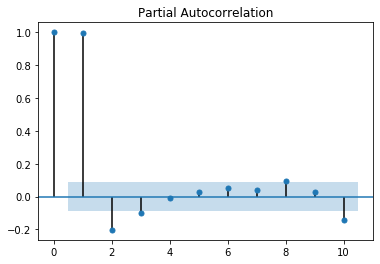

In [8]:
import statsmodels.graphics.tsaplots
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(usd_aud_df, lags=10)
plt.show()

In [8]:
stat_fx_log_eur = np.log(usd_eur_df)
stat_fx_log_usd = np.log(usd_eur_df)
stat_fx_log_diff = stat_fx_log - stat_fx_log.shift(1)
stat_fx_log_diff.dropna(inplace=True)

In [19]:
plot_acf(usd_eur_df, lags =10)

NameError: name 'plot_acf' is not defined

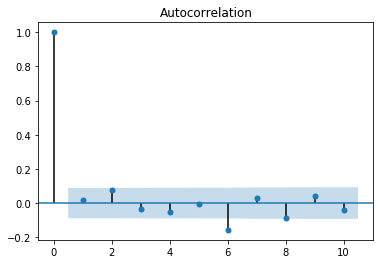

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(stat_fx_log_diff, lags=10)
plt.show()

Text(0.5, 1.0, 'USD/EUR Trend')

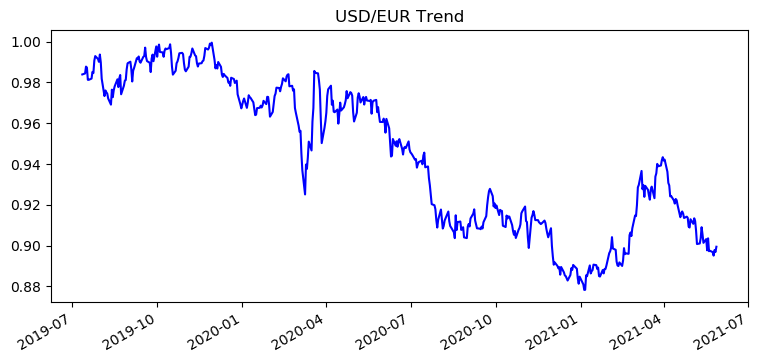

In [12]:
plt.figure(figsize=(9,4), dpi=100)
res = seasonal_decompose(usd_chf_df, model='multiplicative', period =1)
res.trend.plot(color = 'b')
plt.title('USD/EUR Trend')


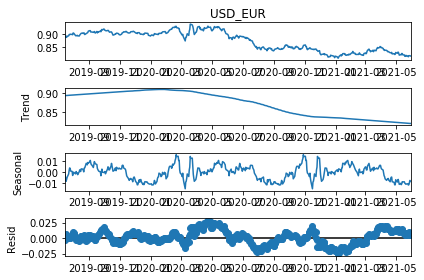

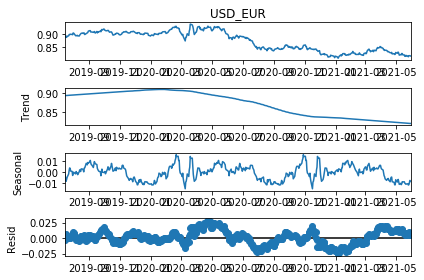

In [21]:
result = seasonal_decompose(usd_eur_df, model='additive', period =180,extrapolate_trend = True)
result.plot()

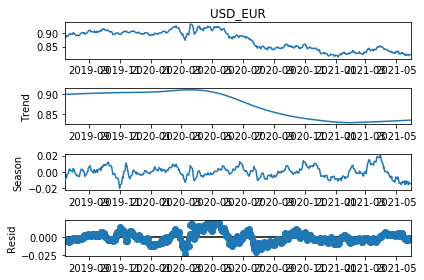

In [98]:
from statsmodels.tsa.seasonal import STL
res = STL(usd_eur_df, period = 90).fit()
res.plot()
plt.show()

In [24]:
stat = usd_eur_df - result.trend - result.seasonal
stat.dropna()

2019-07-14 21:00:00+00:00   -0.002675
2019-07-15 21:00:00+00:00    0.004473
2019-07-16 21:00:00+00:00    0.006038
2019-07-17 21:00:00+00:00    0.000188
2019-07-18 21:00:00+00:00    0.002335
                               ...   
2021-05-24 21:00:00+00:00    0.005400
2021-05-25 21:00:00+00:00    0.009273
2021-05-26 21:00:00+00:00    0.007641
2021-05-27 21:00:00+00:00    0.005628
2021-05-30 21:00:00+00:00    0.004724
Length: 487, dtype: float64

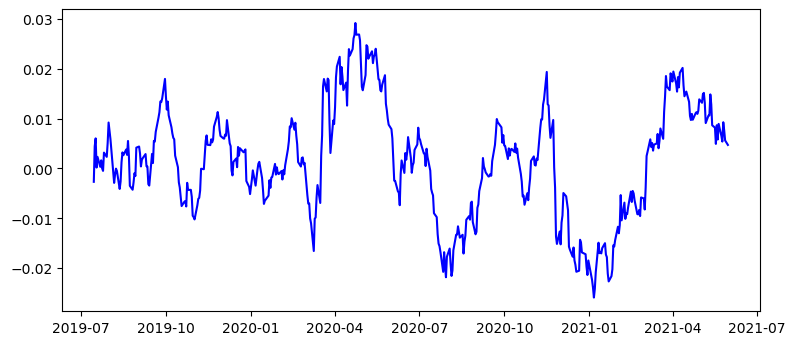

In [25]:
plt.figure(figsize=(9,4), dpi=100)
plt.plot(stat, color = 'b')

In [26]:
kpss_test = kpss(stat, nlags='auto')
print('stat=%.3f, p=%.3f' % kpss_test[0:2])
if kpss_test[1] > 0.05:
    print('Probably Stationary')
else:
    print('Probably not Stationary')

stat=0.234, p=0.100
Probably Stationary


/Users/katarinapetrovic/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [17]:
kpss_test = kpss(usd_eur_df, nlags='auto')
print('p-value: {}'.format(kpss_test[1]))
print('Critical Values:')
for key, value in kpss_test[3].items():
    print('\t{}: {}'.format(key, value))
if kpss_test[1] > 0.05:
    print('Probably Stationary')
else:
    print('Probably not Stationary')

p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Probably not Stationary


/Users/katarinapetrovic/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


In [18]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(usd_eur_df)
print('stat=%.3f, p=%.3f' % adf_test[0:2])
print('ADF Statistic: {}'.format(adf_test[0]))
print('p-value: {}'.format(adf_test[1]))
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t{}: {}'.format(key, value))
if adf_test[1] > 0.05:
 print('Probably not Stationary')
else:
 print('Probably Stationary')


stat=-0.458, p=0.900
ADF Statistic: -0.4582644004040787
p-value: 0.8999068400933177
Critical Values:
	1%: -3.4441047380903007
	5%: -2.867605550172837
	10%: -2.570000704119326
Probably not Stationary


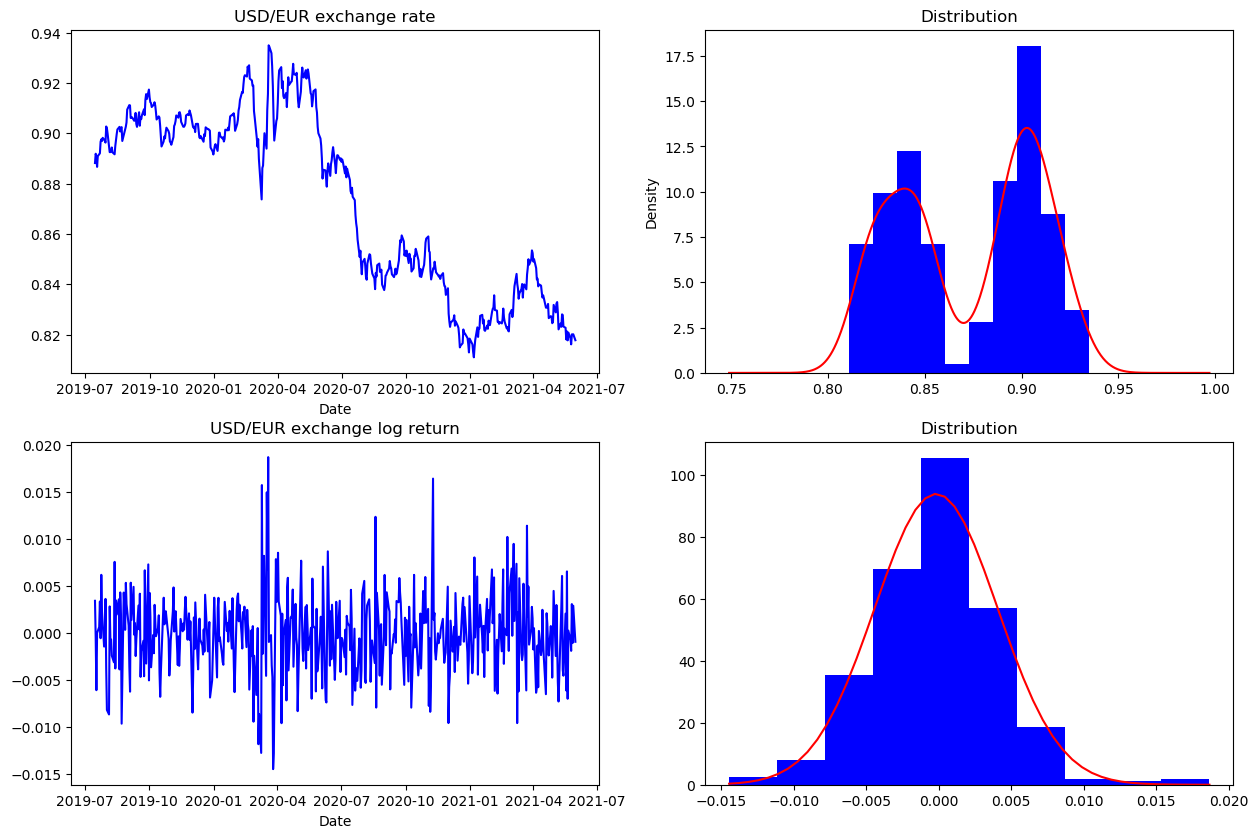

In [63]:
sample_mean = np.mean(stat_fx_log_diff)
sample_std = np.std(stat_fx_log_diff)

dist = norm(sample_mean, sample_std)
domain = np.linspace(np.min(stat_fx_log_diff),np.max(stat_fx_log_diff))
plt.figure(figsize=(15,10), dpi=100)
plt.subplot(221)
plt.plot(usd_eur_df,color = 'blue')
plt.title('USD/EUR exchange rate')
plt.xlabel('Date')
plt.subplot(222)
plt.hist(usd_eur_df, density =True, color = 'blue')
plt.title('Distribution')
usd_eur_df.plot(kind='kde', color = 'r')
plt.subplot(223)
plt.plot(stat_fx_log_diff,color = 'blue')
plt.title('USD/EUR exchange log return')
plt.xlabel('Date')
plt.subplot(224)
plt.plot(domain, norm.pdf(domain, sample_mean, sample_std), color = 'r')
plt.hist(stat_fx_log_diff, density = True, color = 'blue')
plt.title('Distribution')
plt.show()


In [40]:
y_pred_list = usd_eur_df.tolist()
result = seasonal_decompose(y_pred_list, model='additive', period=1)

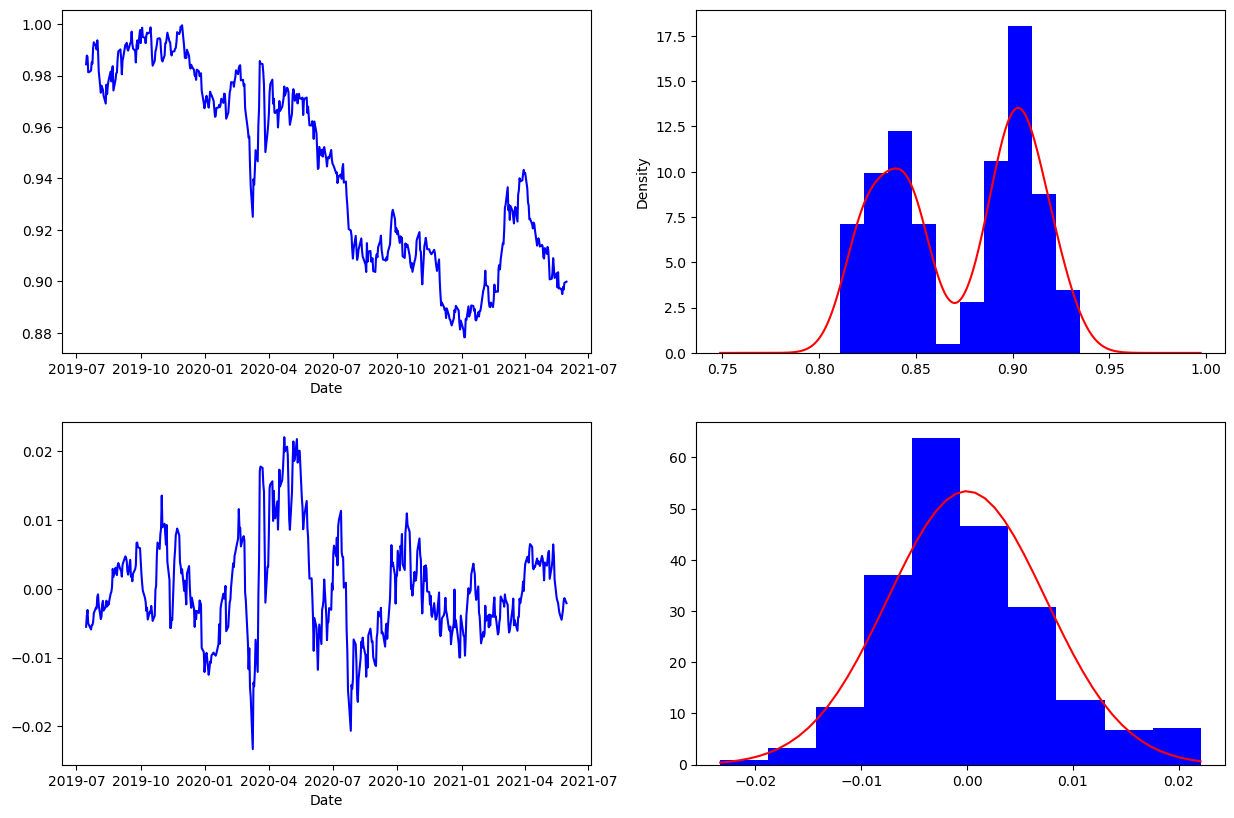

In [104]:
sample_mean = np.mean(stat)
sample_std = np.std(stat)
dist = norm(sample_mean, sample_std)
domain = np.linspace(np.min(stat),np.max(stat))
plt.figure(figsize=(15,10), dpi=100)
plt.subplot(221)
plt.plot(usd_chf_df,color = 'blue')
plt.xlabel('Date')
plt.subplot(222)
plt.hist(usd_eur_df, density =True, color = 'blue')
usd_eur_df.plot(kind='kde', color = 'r')
plt.subplot(223)
plt.plot(stat,color = 'blue')
plt.xlabel('Date')
plt.subplot(224)
plt.plot(domain, norm.pdf(domain, sample_mean, sample_std), color = 'r')
plt.hist(stat, density = True, color = 'blue')
plt.show()

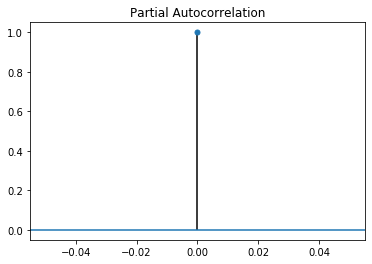

In [42]:
plot_pacf(stat_fx_log_diff, lags=10)
plt.show()

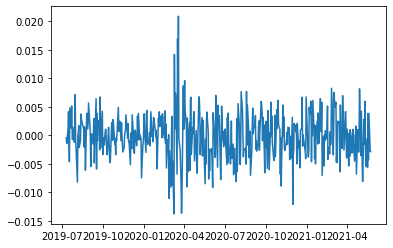

In [43]:
plt.plot(stat_fx_log_diff)

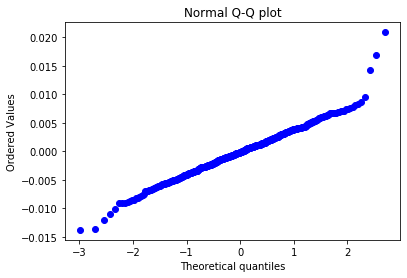

In [61]:
import statsmodels.api as sm
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array([-3,-2,-1,0,1,2,3])
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
import scipy.stats as stats

stats.probplot(stat_fx_log_diff, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [147]:
sample_mean = np.mean(stat_fx_log_diff)
sample_std = np.std(stat_fx_log_diff)

In [76]:
model_arima = ARIMA(stat, (2,0,2))
model_arima_fit = model_arima.fit()
aic = model_arima_fit.bic
print(aic)

/Users/katarinapetrovic/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/katarinapetrovic/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has bee

-4193.63262726183


In [9]:
k = 2
train_data = stat_fx_log[:len(stat_fx_log)-k]
save_data = stat_fx_log[:len(stat_fx_log)-k]
predicted_data = train_data 
N_train = len(train_data)
look1 = np.zeros(k)
look2 = np.zeros(k)
look3 = np.zeros(k)
look4 =  np.zeros(k)
look1_up = np.zeros(k)
look2_up = np.zeros(k)
look3_up = np.zeros(k)
look4_up =  np.zeros(k)
look1_lw = np.zeros(k)
look2_lw = np.zeros(k)
look3_lw = np.zeros(k)
look4_lw =  np.zeros(k)
ind = 0
for i in range(k):
    model_1 = ARIMA(train_data, order=(4,1,2))
    model_fit_1 = model_1.fit()
    predicted_days, se, conf = model_fit_1.forecast(4, alpha=0.05)
    look1[ind] = predicted_days[0]
    look2[ind] = predicted_days[1]
    look3[ind] = predicted_days[2]
    look4[ind] = predicted_days[3]
    look1_up[ind] = conf[:,1][0]
    look2_up[ind] = conf[:,1][1]
    look3_up[ind] = conf[:,1][2]
    look4_up[ind] = conf[:,1][3]
    look1_lw[ind] = conf[:,0][0]
    look2_lw[ind] = conf[:,0][1]
    look3_lw[ind] = conf[:,0][2]
    look4_lw[ind] = conf[:,0][3]
    ind = ind+1
    train_data = stat_fx_log[:len(stat_fx_log)-k+i]
    
look_1_predict = save_data
look_2_predict = stat_fx_log[:len(stat_fx_log)-k+1]
look_3_predict = stat_fx_log[:len(stat_fx_log)-k+2]
look_4_predict = stat_fx_log[:len(stat_fx_log)-k+3]
look1 = pd.Series(look1, index = fx_px_df.index[-k:])
look2= pd.Series(look2, index = fx_px_df.index[-k:])
look3 = pd.Series(look3, index = fx_px_df.index[-k:])
look4= pd.Series(look4, index = fx_px_df.index[-k:])
look_1_predict = look_1_predict.append(look1)
look_2_predict = look_2_predict.append(look2)
look_3_predict = look_3_predict.append(look3)
look_4_predict = look_4_predict.append(look4)

look_1_predict_up = save_data
look_2_predict_up = stat_fx_log[:len(stat_fx_log)-k+1]
look_3_predict_up = stat_fx_log[:len(stat_fx_log)-k+2]
look_4_predict_up = stat_fx_log[:len(stat_fx_log)-k+3]
look1_up = pd.Series(look1_up, index = fx_px_df.index[-k:])
look2_up= pd.Series(look2_up, index = fx_px_df.index[-k:])
look3_up = pd.Series(look3_up, index = fx_px_df.index[-k:])
look4_up= pd.Series(look4_up, index = fx_px_df.index[-k:])
look_1_predict_up = look_1_predict_up.append(look1_up)
look_2_predict_up = look_2_predict_up.append(look2_up)
look_3_predict_up = look_3_predict_up.append(look3_up)
look_4_predict_up = look_4_predict_up.append(look4_up)

look_1_predict_lw = save_data
look_2_predict_lw = stat_fx_log[:len(stat_fx_log)-k+1]
look_3_predict_lw = stat_fx_log[:len(stat_fx_log)-k+2]
look_4_predict_lw = stat_fx_log[:len(stat_fx_log)-k+3]
look1_lw = pd.Series(look1_lw, index = fx_px_df.index[-k:])
look2_lw= pd.Series(look2_lw, index = fx_px_df.index[-k:])
look3_lw = pd.Series(look3_lw, index = fx_px_df.index[-k:])
look4_lw= pd.Series(look4_lw, index = fx_px_df.index[-k:])
look_1_predict_lw = look_1_predict_lw.append(look1_lw)
look_2_predict_lw = look_2_predict_lw.append(look2_lw)
look_3_predict_lw = look_3_predict_lw.append(look3_lw)
look_4_predict_lw = look_4_predict_lw.append(look4_lw)


/Users/katarinapetrovic/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/katarinapetrovic/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has bee

/Users/katarinapetrovic/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/katarinapetrovic/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/katarinapetrovic/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 0, 'Date')

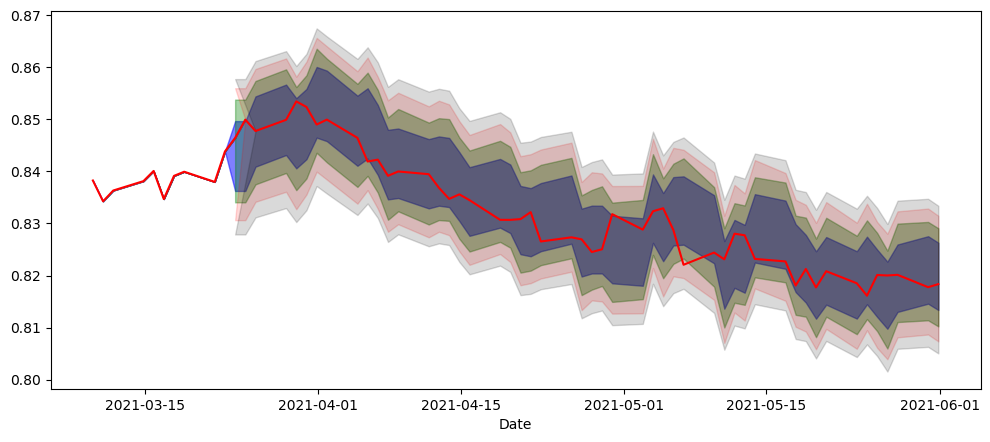

In [21]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(usd_eur_df.index[-60:], usd_eur_df[-60:],color = 'r')
plt.fill_between(look_1_predict_lw.index[-60:], np.exp(look_1_predict_lw)[-60:], np.exp(look_1_predict_up)[-60:], 
                 color='b', alpha=.5)
plt.fill_between(look_2_predict_lw.index[-60:], np.exp(look_2_predict_lw)[-60:], np.exp(look_2_predict_up)[-60:], 
                 color='g', alpha=.35)
plt.fill_between(look_3_predict_lw.index[-60:], np.exp(look_3_predict_lw)[-60:], np.exp(look_3_predict_up)[-60:], 
                 color='r', alpha=.15)
plt.fill_between(look_4_predict_lw.index[-60:], np.exp(look_4_predict_lw)[-60:], np.exp(look_4_predict_up)[-60:], 
                 color='k', alpha=.15)
#plt.title('USD/CHF 95% confidence interval prediction for ' + r'$H=50$')
plt.xlabel('Date')

In [35]:
#find the rmse for different time series
from sklearn.metrics import mean_squared_error

test = usd_eur_df[-50:]
mse1 = mean_squared_error(np.exp(look_1_predict_up[-50:]), test)
rmse1 = sqrt(mse1)
mse2 = mean_squared_error(np.exp(look_2_predict_up[-49:]), test[1:])
rmse2 = sqrt(mse2)
mse3 = mean_squared_error(np.exp(look_3_predict_up[-48:]), test[2:])
rmse3 = sqrt(mse3)
mse4 = mean_squared_error(np.exp(look_4_predict_up[-47:]), test[3:])
rmse4 = sqrt(mse4)

In [36]:
np.exp(look_1_predict[-50])

0.8429366598726143

In [38]:
print(rmse1*100)
print(rmse2*100)
print(rmse3*100)
print(rmse4*100)

0.8426682378365274
1.1322980799071118
1.4047285724749627
1.6234131709095114


## Create a new data set

In [10]:
#create the eur_usd rates data for look ahead 1
eur_usd_look1 = 1/np.exp(look1)
#create the column for eur_eur and usd_usd
N = look1.shape[0]
eq = np.ones(N)
usd_usd_df = pd.Series(eq, index = fx_px_df.index[-k:])
eur_eur_df = pd.Series(eq, index = fx_px_df.index[-k:])
#concatenate it all
c1 = pd.concat([usd_usd_df, np.exp(look1)], axis=1)
c2 = pd.concat([c1, eur_usd_look1], axis=1)
fx_px_pred_look1 = pd.concat([c2, eur_eur_df], axis=1)


In [11]:
fx_px_pred_look1.dropna()

,0,1,0,0
2021-03-24 21:00:00+00:00,1.0,0.847641,1.179745,1.0
2021-03-25 21:00:00+00:00,1.0,0.847641,1.179745,1.0
2021-03-28 21:00:00+00:00,1.0,0.849919,1.176583,1.0
2021-03-29 21:00:00+00:00,1.0,0.847342,1.180161,1.0
2021-03-30 21:00:00+00:00,1.0,0.849117,1.177694,1.0
2021-03-31 21:00:00+00:00,1.0,0.853308,1.171909,1.0
2021-04-01 21:00:00+00:00,1.0,0.852552,1.172949,1.0
2021-04-04 21:00:00+00:00,1.0,0.847834,1.179476,1.0
2021-04-05 21:00:00+00:00,1.0,0.849247,1.177514,1.0
2021-04-06 21:00:00+00:00,1.0,0.846021,1.182004,1.0


In [16]:
fx_px_pred_look1.columns = fx_px_df.columns

In [17]:
fx_px_pred_look1.dropna()

,USD_USD,USD_EUR,EUR_USD,EUR_EUR
2021-05-26 21:00:00+00:00,1.0,0.819514,1.220235,1.0
2021-05-27 21:00:00+00:00,1.0,0.819514,1.220235,1.0
2021-05-30 21:00:00+00:00,1.0,0.821012,1.218008,1.0
2021-05-31 21:00:00+00:00,1.0,0.819834,1.219759,1.0
2021-06-01 21:00:00+00:00,1.0,0.817424,1.223355,1.0


In [18]:
fx_px_pred_look1.shape

(5, 4)

## Experiements

# Single path experiement - Dijkstra algorithm

In [27]:
# Dijkstra Implementation
def dijkstra(fx_dist_mtrx):
    added = np.absolute(np.amin(fx_dist_mtrx))
    fx_dist_mtrx = fx_dist_mtrx + added
    dist_matrix_d, predecessors_d = sp.sparse.csgraph.shortest_path(fx_dist_mtrx, method='D', return_predecessors=True)
    return dist_matrix_d, predecessors_d, added

# Solving the problem
begin_time = time.time()
dist_matrix_d, predecessors_d, added = dijkstra(fx_dist_mtrx_masked)
dijkstra_time = time.time() - begin_time
path = idx_to_curncy(predecessor_to_list(predecessors_d,num_timesteps,num_curncy),num_curncy,fx_px_time,curncy_list)
print("Dijkstra: 1 USD In, {out} USDs Out. Used time: {used_time}".format(
    out = np.exp(-dist_matrix_d[0,num_timesteps*num_curncy]+added*num_timesteps),
    used_time = dijkstra_time))
print("Dijkstra Path: {path}".format(path=path))

optimal_draw_list = [('_'.join((path.to_numpy()[i,0],str(i))),'_'.join((path.to_numpy()[i+1,0],str(i+1)))) for i in range(num_timesteps)]

weight_mtrx_dijkstra = pd.DataFrame(np.zeros((num_timesteps,num_curncy**2)), index = fx_px_df.index, columns = fx_px_df.columns)
weight_mtrx_dijkstra = fx_px_to_graph(weight_mtrx_dijkstra, curncy_list)
for pos in optimal_draw_list:
    weight_mtrx_dijkstra.loc[pos] = 1
    
# Plots the problem in directed graph with the optimal solution
plot_fx_digraph(fx_graph_mtrx, weight_mtrx_dijkstra, num_curncy, num_timesteps)

NameError: name 'fx_dist_mtrx_masked' is not defined

In [12]:
#this is the set of constraints for the 2x2 example: "USD" and "EUR"
best_mut_2_2 = np.array([0.92632099, 0.9239593 , 0.28411957, 0.91450589, 0.85818732,
       0.79968513, 0.46892327, 0.61577307])
best_mut_2_3 = np.array([0.60599359, 0.59604336, 0.79898611, 0.95128462, 0.72730944,
       0.50605346, 0.98108167, 0.74083392, 0.95565663, 0.32129021,
       0.5581402 , 0.64779173])
best_mut_2_5 = np.array([0.53088834, 0.9831448 , 0.22395021, 0.42177898, 0.18545939,
       0.02246608, 0.5881773 , 0.70806597, 0.31146801, 0.15457424,
       0.06812182, 0.66753143, 0.34756596, 0.03800664, 0.39665706,
       0.42437249, 0.89942015, 0.3404204 , 0.80955863, 0.30547812])
best_mut_2_10 = np.array([0.81331871, 0.47140562, 0.84623459, 0.21776941, 0.93583716,
       0.3770481 , 0.19603215, 0.17415001, 0.7950071 , 0.43012551,
       0.84623509, 0.78422795, 0.42144503, 0.83645012, 0.78247443,
       0.96291992, 0.03089332, 0.58604525, 0.86739556, 0.02396736,
       0.75248184, 0.81819609, 0.11987461, 0.11592574, 0.85268176,
       0.50558929, 0.57623588, 0.44945825, 0.60737778, 0.45245361,
       0.84259197, 0.23331213, 0.44755994, 0.829964  , 0.53858104,
       0.58136771, 0.94318984, 0.51420966, 0.67246714, 0.90697527])
best_mut_2_50 = np.array([0.81331871, 0.47140562, 0.84623459, 0.21776941, 0.93583716,
       0.3770481 , 0.19603215, 0.17415001, 0.7950071 , 0.43012551,
       0.84623509, 0.78422795, 0.42144503, 0.83645012, 0.78247443,
       0.96291992, 0.03089332, 0.58604525, 0.86739556, 0.02396736,
       0.75248184, 0.81819609, 0.11987461, 0.11592574, 0.85268176,
       0.50558929, 0.57623588, 0.44945825, 0.60737778, 0.45245361,
       0.84259197, 0.23331213, 0.44755994, 0.829964  , 0.53858104,
       0.58136771, 0.94318984, 0.51420966, 0.67246714, 0.90697527,0.81331871, 0.47140562, 0.84623459, 0.21776941, 0.93583716,
       0.3770481 , 0.19603215, 0.17415001, 0.7950071 , 0.43012551,
       0.84623509, 0.78422795, 0.42144503, 0.83645012, 0.78247443,
       0.96291992, 0.03089332, 0.58604525, 0.86739556, 0.02396736,
       0.75248184, 0.81819609, 0.11987461, 0.11592574, 0.85268176,
       0.50558929, 0.57623588, 0.44945825, 0.60737778, 0.45245361,
       0.84259197, 0.23331213, 0.44755994, 0.829964  , 0.53858104,
       0.58136771, 0.94318984, 0.51420966, 0.67246714, 0.90697527,0.81331871, 0.47140562, 0.84623459, 0.21776941, 0.93583716,
       0.3770481 , 0.19603215, 0.17415001, 0.7950071 , 0.43012551,
       0.84623509, 0.78422795, 0.42144503, 0.83645012, 0.78247443,
       0.96291992, 0.03089332, 0.58604525, 0.86739556, 0.02396736,
       0.75248184, 0.81819609, 0.11987461, 0.11592574, 0.85268176,
       0.50558929, 0.57623588, 0.44945825, 0.60737778, 0.45245361,
       0.84259197, 0.23331213, 0.44755994, 0.829964  , 0.53858104,
       0.58136771, 0.94318984, 0.51420966, 0.67246714, 0.90697527,0.81331871, 0.47140562, 0.84623459, 0.21776941, 0.93583716,
       0.3770481 , 0.19603215, 0.17415001, 0.7950071 , 0.43012551,
       0.84623509, 0.78422795, 0.42144503, 0.83645012, 0.78247443,
       0.96291992, 0.03089332, 0.58604525, 0.86739556, 0.02396736,
       0.75248184, 0.81819609, 0.11987461, 0.11592574, 0.85268176,
       0.50558929, 0.57623588, 0.44945825, 0.60737778, 0.45245361,
       0.84259197, 0.23331213, 0.44755994, 0.829964  , 0.53858104,
       0.58136771, 0.94318984, 0.51420966, 0.67246714, 0.90697527,0.81331871, 0.47140562, 0.84623459, 0.21776941, 0.93583716,
       0.3770481 , 0.19603215, 0.17415001, 0.7950071 , 0.43012551,
       0.84623509, 0.78422795, 0.42144503, 0.83645012, 0.78247443,
       0.96291992, 0.03089332, 0.58604525, 0.86739556, 0.02396736,
       0.75248184, 0.81819609, 0.11987461, 0.11592574, 0.85268176,
       0.50558929, 0.57623588, 0.44945825, 0.60737778, 0.45245361,
       0.84259197, 0.23331213, 0.44755994, 0.829964  , 0.53858104,
       0.58136771, 0.94318984, 0.51420966, 0.67246714, 0.90697527])
best_mut_3_2= np.array([0.99452499, 0.30795247, 0.24298652, 0.62972265, 0.99145937,
       0.75921981, 0.6730296 , 0.39696766, 0.34726792, 0.52178037,
       0.38624934, 0.03457585, 0.98626184, 0.09619085, 0.86351428,
       0.3548268 , 0.40979468, 0.28884129])
best_mut_3_3 = np.array([0.81373877, 0.31313577, 0.30454242, 0.41031145, 0.67757518,
       0.77709709, 0.15487387, 0.28216085, 0.38188395, 0.43318463,
       0.03801381, 0.798059  , 0.1244967 , 0.81267204, 0.03579757,
       0.26815422, 0.97773988, 0.93145449, 0.5068769 , 0.29432285,
       0.61820944, 0.57823586, 0.5811678 , 0.11412945, 0.32611535,
       0.22399801, 0.5201397 ])
best_mut_3_5 = np.array([0.74685194, 0.10067986, 0.51592576, 0.54130256, 0.63138955,
       0.1437431 , 0.93100081, 0.06610387, 0.39048464, 0.34340173,
       0.03390041, 0.13447781, 0.0123483 , 0.8432107 , 0.82499555,
       0.18507364, 0.42011568, 0.90189171, 0.48479426, 0.13996018,
       0.88030727, 0.71965424, 0.6869806 , 0.96962021, 0.34807449,
       0.20979856, 0.72231898, 0.01308352, 0.60304387, 0.64126247,
       0.1676298 , 0.69274105, 0.51605994, 0.14365375, 0.53037401,
       0.74024846, 0.87265746, 0.4153938 , 0.75446604, 0.81250825,
       0.27722944, 0.83438559, 0.87956926, 0.95678696, 0.36267638])
best_mut_3_10 = np.array([0.76143632, 0.16068017, 0.14951949, 0.89362166, 0.55156742,
       0.68873079, 0.38004165, 0.39419877, 0.95667183, 0.45605023,
       0.5833262 , 0.96298179, 0.93273985, 0.76389432, 0.21681611,
       0.59230512, 0.67927673, 0.01769322, 0.87323689, 0.18927572,
       0.26043965, 0.72701672, 0.60172527, 0.84330645, 0.40805328,
       0.88967088, 0.43735475, 0.74860236, 0.68066934, 0.38953048,
       0.44197152, 0.25879707, 0.65930033, 0.90363722, 0.66603744,
       0.38886806, 0.67624221, 0.81800265, 0.95297957, 0.80505167,
       0.95999748, 0.66966365, 0.09804604, 0.79097383, 0.57744593,
       0.66517967, 0.09428037, 0.40510296, 0.92961028, 0.01010833,
       0.35837515, 0.46278558, 0.92421403, 0.74933867, 0.52427928,
       0.78375706, 0.76402892, 0.14119404, 0.72955787, 0.43567841,
       0.19846535, 0.12600164, 0.45947322, 0.40842859, 0.70811554,
       0.7793105 , 0.91908969, 0.43633571, 0.83584494, 0.07146316,
       0.41449353, 0.9025915 , 0.23662624, 0.90067933, 0.34769398,
       0.86254765, 0.36018853, 0.41952387, 0.34168894, 0.18086143,
       0.95513956, 0.36074831, 0.7229709 , 0.71030537, 0.90879255,
       0.59083758, 0.01862065, 0.89859495, 0.36424317, 0.33712237])
best_mut_3_50 = np.array([5.85829824e-01, 9.49864861e-01, 8.38257897e-01, 8.63968202e-01,
       7.17747816e-01, 3.32106182e-01, 3.38322572e-01, 7.56894440e-02,
       5.98463429e-01, 1.30475087e-01, 5.12922833e-01, 3.45304837e-03,
       2.01670622e-01, 4.46369162e-01, 7.54018720e-01, 1.60395993e-01,
       4.40488296e-01, 9.70208529e-02, 8.83907385e-01, 5.64941579e-01,
       6.04436674e-01, 1.00323878e-01, 2.32330628e-02, 7.59484392e-01,
       7.29122885e-01, 1.05058764e-02, 6.76322526e-01, 2.16000322e-01,
       6.20676769e-01, 3.92895767e-02, 4.20797801e-01, 8.26933811e-01,
       4.72912852e-01, 7.59691421e-01, 1.70079712e-01, 3.34550826e-01,
       7.57557883e-01, 8.96343984e-01, 3.78273138e-01, 9.06929806e-01,
       2.72041246e-01, 7.59127564e-01, 4.55648232e-01, 3.32083250e-01,
       3.89585566e-01, 7.88857935e-01, 2.41553852e-01, 6.44691871e-03,
       2.16129341e-02, 7.53884667e-01, 3.97289657e-01, 3.15859245e-01,
       8.06051836e-01, 6.78818704e-01, 8.29969102e-01, 8.09005280e-01,
       4.14307556e-01, 6.77633527e-01, 6.41817767e-01, 8.07892309e-01,
       4.17735082e-01, 2.13525230e-01, 1.92209917e-01, 3.90869994e-01,
       9.94592039e-01, 3.15926111e-01, 1.32861841e-01, 4.64218614e-01,
       4.20374581e-02, 1.47556376e-01, 1.26267685e-01, 6.14173827e-01,
       5.56971057e-01, 5.50719375e-01, 8.51272898e-01, 5.04299209e-01,
       3.73127793e-01, 5.79765132e-02, 8.77572017e-01, 3.67782608e-01,
       3.05780321e-01, 8.82217816e-01, 6.53409521e-01, 4.97458445e-01,
       7.74544271e-01, 1.13819231e-02, 7.72443374e-01, 2.49761908e-03,
       9.17436558e-02, 8.15611301e-01, 4.72352486e-01, 2.00066270e-01,
       1.45892273e-01, 6.87551546e-02, 2.42946724e-01, 8.72936718e-02,
       3.75603412e-01, 1.09877993e-01, 1.49219018e-02, 5.54736295e-01,
       7.53890046e-01, 2.90988747e-01, 1.07334724e-01, 1.15229897e-01,
       5.06312939e-01, 5.81216682e-01, 9.33775792e-01, 3.27389320e-01,
       8.14901338e-01, 7.38096875e-01, 6.77832302e-01, 6.23213848e-01,
       6.17054938e-01, 9.05523105e-01, 1.86100976e-01, 8.28890142e-01,
       6.45675543e-01, 1.95059601e-01, 7.64207067e-01, 7.40451348e-01,
       1.90638076e-01, 8.77971549e-01, 3.21297298e-01, 8.82165691e-01,
       2.95289816e-01, 3.34270407e-01, 8.89106945e-02, 5.91065447e-01,
       2.65600826e-02, 4.81638703e-01, 9.00021407e-02, 6.92723256e-01,
       9.27620466e-01, 3.37553674e-01, 6.35390494e-01, 1.67801736e-01,
       6.97822007e-01, 6.84307925e-01, 1.09379288e-01, 5.77537685e-01,
       3.19745353e-01, 3.82072630e-01, 2.25020865e-01, 8.74661151e-01,
       4.38040161e-01, 8.08551748e-01, 4.83895760e-01, 5.52008970e-01,
       9.87332676e-01, 6.73092759e-01, 4.54325052e-01, 9.66137392e-01,
       1.06511883e-01, 7.19041724e-01, 6.57659381e-01, 9.48138002e-01,
       8.19533827e-01, 1.10597071e-01, 4.72248146e-01, 6.90832499e-01,
       4.58351732e-01, 6.35709897e-01, 3.27539404e-01, 7.95043845e-01,
       5.37476706e-01, 4.87175644e-01, 9.94041099e-01, 1.04118209e-01,
       6.96624060e-01, 2.58956360e-01, 9.52200684e-01, 9.78528646e-01,
       2.83793351e-01, 9.33756371e-01, 2.21606810e-02, 6.98734156e-01,
       4.90326035e-01, 7.24780311e-01, 5.67841000e-01, 6.76903755e-01,
       2.65995862e-01, 6.42029674e-01, 2.18201449e-01, 7.80287949e-01,
       8.66769088e-01, 4.82063130e-01, 4.34580474e-02, 1.47970293e-01,
       8.97793876e-01, 5.52403051e-01, 9.37733213e-01, 7.01563811e-01,
       4.08860390e-01, 7.64006043e-01, 2.43773420e-02, 4.31573234e-01,
       5.50831385e-01, 9.00841133e-01, 3.47450905e-01, 7.40136459e-04,
       7.86910081e-01, 1.10343394e-01, 8.88794962e-01, 2.94059999e-01,
       1.24808061e-01, 6.92203273e-01, 2.20134749e-01, 4.83629720e-01,
       5.55440572e-01, 8.53288615e-01, 2.62999285e-01, 8.04693838e-01,
       3.15282155e-01, 1.72287233e-01, 6.85184352e-01, 9.52637170e-02,
       4.72003511e-02, 9.36826969e-01, 6.34648720e-01, 7.43122848e-01,
       7.90705283e-01, 1.51808034e-01, 4.66735612e-01, 4.99157225e-02,
       4.06306261e-01, 5.89481145e-01, 7.37307135e-01, 9.54395223e-01,
       8.45209771e-01, 6.69687249e-01, 5.48738319e-02, 5.80351197e-01,
       7.88412894e-01, 5.08423825e-01, 9.01736900e-01, 7.70303990e-01,
       1.67196187e-01, 1.50430903e-02, 3.46889844e-02, 6.77473042e-01,
       2.99882034e-01, 9.99191908e-01, 4.30884823e-01, 7.59543697e-01,
       1.16331563e-01, 8.30193566e-01, 8.84411970e-01, 8.92523751e-01,
       7.25544405e-01, 5.94119996e-01, 4.35367985e-01, 9.89739754e-01,
       2.35979961e-01, 3.26212688e-01, 6.39303934e-01, 9.82759881e-01,
       3.37838249e-01, 4.16962290e-01, 3.19223896e-01, 3.52899535e-01,
       9.35010996e-01, 1.74281933e-01, 9.25668951e-01, 2.72822842e-01,
       6.45775536e-01, 3.01610625e-01, 6.65734133e-01, 1.57044013e-02,
       1.33426276e-01, 9.17689094e-01, 1.36117211e-01, 1.08269492e-02,
       7.70122725e-01, 7.86193172e-01, 6.66191287e-01, 4.35745212e-01,
       3.11562846e-01, 8.97306559e-01, 9.51725362e-01, 9.68850722e-01,
       2.81931869e-01, 9.09947107e-02, 4.91640954e-01, 6.02233216e-01,
       4.13760536e-01, 5.60656279e-02, 3.23719397e-02, 9.45789142e-04,
       5.09954371e-01, 1.70890994e-01, 5.90115345e-01, 4.19816604e-01,
       5.17089057e-01, 3.92976061e-01, 2.29515256e-01, 5.02297664e-01,
       5.42465864e-01, 6.02960347e-01, 7.61169024e-01, 8.92126998e-01,
       9.32330732e-01, 2.74527240e-01, 2.87957865e-01, 9.53413434e-01,
       1.17389930e-01, 4.52572912e-01, 5.83659758e-01, 6.47831624e-01,
       4.28256216e-01, 4.80725219e-01, 3.38341001e-01, 8.55683237e-01,
       3.73468546e-02, 6.84365689e-01, 4.93547041e-01, 4.82353481e-01,
       4.13100517e-01, 5.02222427e-02, 5.29322494e-01, 9.63750870e-01,
       3.02242105e-01, 1.27302606e-01, 2.30962247e-01, 2.05855442e-01,
       9.23999217e-01, 8.02347325e-01, 2.31732156e-01, 4.94820429e-03,
       6.09358971e-01, 1.45483179e-01, 4.89790469e-01, 6.51621183e-01,
       8.74277117e-01, 6.34654354e-01, 4.27034788e-01, 8.52103296e-01,
       6.42274090e-01, 7.74762821e-01, 7.43238276e-01, 8.55578287e-01,
       6.98163923e-01, 3.04158327e-03, 3.27376194e-01, 5.01121277e-01,
       9.21273941e-01, 2.25455841e-01, 7.17619212e-01, 3.36161746e-01,
       7.85037389e-01, 6.71094541e-02, 9.01112069e-01, 2.38725113e-01,
       1.31497060e-01, 2.31815395e-01, 8.91281092e-01, 9.63151271e-01,
       2.43862227e-01, 7.17284512e-01, 1.90276366e-01, 7.69405216e-01,
       6.86179876e-02, 1.38353951e-01, 8.99913418e-01, 6.34022811e-03,
       3.05070561e-01, 1.80750371e-01, 5.38715727e-01, 5.84714508e-01,
       4.94603727e-01, 1.45138544e-01, 4.95479089e-01, 3.23584431e-01,
       9.53159198e-01, 9.71216840e-01, 3.82921405e-01, 1.26314035e-01,
       4.53114366e-01, 7.33298921e-01, 8.63195819e-02, 1.18764816e-01,
       3.49936833e-01, 7.38829072e-01, 6.19932093e-01, 7.74952383e-01,
       1.18255676e-01, 1.54926194e-01, 6.80510638e-01, 7.48540870e-01,
       1.56163316e-01, 6.30944506e-01, 2.78830400e-01, 6.33515110e-01,
       8.54537113e-01, 8.30950964e-01, 8.47451116e-01, 1.53501877e-01,
       1.42578680e-02, 6.41868493e-01, 1.53263776e-01, 7.19443107e-01,
       2.51845389e-01, 7.70859332e-01, 2.84739626e-01, 2.56435619e-01,
       7.83378480e-01, 2.28541196e-03, 6.29822530e-01, 5.41161872e-01,
       4.64551029e-01, 9.39250355e-01, 3.76253983e-01, 1.50641165e-01,
       9.77595106e-01, 4.03388100e-01, 7.17489061e-01, 7.01851525e-02,
       5.29542398e-02, 1.72682306e-01, 6.80613753e-01, 9.72190227e-02,
       9.47162197e-01, 2.36347067e-01, 9.67057187e-01, 7.99949133e-02,
       8.23538527e-01, 6.82558565e-02, 7.55360104e-01, 3.98684867e-01,
       1.57334795e-01, 5.13304491e-01, 3.21510855e-01, 5.99495134e-01,
       1.35872903e-01, 3.36244928e-01, 6.84328953e-01, 9.66235072e-01,
       3.64700095e-01, 9.10096826e-01, 5.07499384e-01, 4.79033086e-01,
       4.26350545e-01, 4.88306793e-01, 1.45569632e-02, 2.68322502e-01,
       5.03901737e-01, 4.96883107e-01, 9.07828463e-01, 4.09246446e-01,
       3.30228879e-01, 7.14473372e-01])
best_mut_6_2 = np.array([0.55227402, 0.02126897, 0.01123776, 0.70972002, 0.08932677,
       0.50214824, 0.91106083, 0.51410486, 0.26099242, 0.13422173,
       0.66604853, 0.50119323, 0.42906763, 0.15062345, 0.6876349 ,
       0.73601524, 0.33839091, 0.65760046, 0.76617784, 0.87954366,
       0.89708121, 0.39698635, 0.63960859, 0.59492015, 0.24734741,
       0.50373644, 0.52740493, 0.6320841 , 0.3034097 , 0.83281446,
       0.30747711, 0.9955239 , 0.94210536, 0.66058937, 0.62460938,
       0.25487418, 0.82794158, 0.19225153, 0.96944293, 0.67742351,
       0.39413434, 0.03679023, 0.92046233, 0.97930199, 0.4114388 ,
       0.90689247, 0.61816181, 0.28578059, 0.75167366, 0.11111349,
       0.49046924, 0.51460738, 0.54615905, 0.15456011, 0.03314834,
       0.10222914, 0.26016119, 0.40157659, 0.66907878, 0.86688362,
       0.69472681, 0.74981246, 0.81387508, 0.19985223, 0.69276281,
       0.18991874, 0.8786395 , 0.19016106, 0.44833909, 0.62504897,
       0.02026925, 0.01561148])
best_mut_6_3 = np.array([0.71257541, 0.53151208, 0.06319215, 0.11903795, 0.37998604,
       0.92887083, 0.87832796, 0.91857606, 0.66860196, 0.20447104,
       0.66991604, 0.93406025, 0.54038951, 0.51073486, 0.85052706,
       0.96537461, 0.59939668, 0.98817695, 0.11805509, 0.46389562,
       0.3777319 , 0.3711045 , 0.69368047, 0.54752643, 0.50364748,
       0.56068274, 0.39916232, 0.80073182, 0.91502402, 0.51454751,
       0.43957869, 0.34877808, 0.41735867, 0.16260489, 0.60333479,
       0.64966581, 0.13743418, 0.27037894, 0.32625704, 0.78420444,
       0.66262748, 0.57133178, 0.9407701 , 0.74743763, 0.16054877,
       0.3886777 , 0.17767808, 0.01692131, 0.63395796, 0.77864506,
       0.06199607, 0.01819442, 0.68461934, 0.73062421, 0.10996828,
       0.92330765, 0.37731406, 0.809828  , 0.01966852, 0.64484334,
       0.73212818, 0.48427784, 0.63624406, 0.27525094, 0.57710664,
       0.99135964, 0.97060413, 0.12562635, 0.2137511 , 0.05566923,
       0.57329611, 0.94083359, 0.32904342, 0.72741089, 0.95528388,
       0.79357096, 0.37962154, 0.81719987, 0.86270238, 0.80807523,
       0.29669917, 0.1373151 , 0.78453505, 0.27279046, 0.60617428,
       0.15020016, 0.08993815, 0.60586188, 0.05323898, 0.70669275,
       0.17634429, 0.43150821, 0.78906691, 0.22272073, 0.68267922,
       0.05154644, 0.14133559, 0.95728679, 0.74621259, 0.65323741,
       0.34407614, 0.09877232, 0.72126331, 0.09579178, 0.46535751,
       0.81717085, 0.65060215, 0.58837856])
best_mut_6_10 = np.array([0.28830019, 0.96685963, 0.10571802, 0.91739724, 0.56357059,
       0.53166113, 0.08221481, 0.23747606, 0.15235628, 0.3745567 ,
       0.21105681, 0.77045489, 0.51784715, 0.11133626, 0.30206661,
       0.51699214, 0.16461112, 0.64179199, 0.58890959, 0.42624583,
       0.69518573, 0.01132425, 0.68556006, 0.2587266 , 0.54573308,
       0.04200063, 0.73529495, 0.74901767, 0.45630574, 0.27360623,
       0.97707021, 0.54184065, 0.7225013 , 0.91998229, 0.62396206,
       0.47109047, 0.17015603, 0.77050813, 0.79432284, 0.67947559,
       0.63387121, 0.3617357 , 0.29637542, 0.12440311, 0.45189676,
       0.40651634, 0.8649187 , 0.69156359, 0.63888561, 0.42019724,
       0.60319402, 0.14100497, 0.65705223, 0.75130069, 0.80509973,
       0.1911507 , 0.89217129, 0.57279257, 0.96409123, 0.54005704,
       0.93529651, 0.12040186, 0.75916218, 0.4414788 , 0.25257216,
       0.50470942, 0.9344795 , 0.18480562, 0.81709161, 0.27426676,
       0.03787106, 0.34842977, 0.267033  , 0.47935011, 0.23103945,
       0.66046873, 0.40302837, 0.46013498, 0.19929354, 0.87876607,
       0.05264012, 0.98706439, 0.68955978, 0.20161242, 0.6766907 ,
       0.03079669, 0.15530737, 0.19540647, 0.34058803, 0.97825195,
       0.45398782, 0.05935952, 0.91522056, 0.01441797, 0.57475655,
       0.35528831, 0.31684583, 0.08380845, 0.00891261, 0.28543383,
       0.01602507, 0.46472573, 0.29320467, 0.21039184, 0.59329723,
       0.08197304, 0.25478767, 0.62706364, 0.12231994, 0.78377194,
       0.03987634, 0.82517949, 0.63326019, 0.53934575, 0.18748738,
       0.74589021, 0.76856099, 0.09751269, 0.30253213, 0.18334365,
       0.399682  , 0.24510273, 0.00863511, 0.64002059, 0.78256249,
       0.12032545, 0.8894224 , 0.54728791, 0.00347561, 0.81395324,
       0.79202448, 0.49749088, 0.21957394, 0.99308775, 0.5903055 ,
       0.2055275 , 0.54423982, 0.75167841, 0.32326452, 0.64635864,
       0.79446271, 0.20955566, 0.31254296, 0.37643377, 0.17593372,
       0.49500674, 0.19736608, 0.279127  , 0.98742304, 0.59494686,
       0.12126394, 0.09408484, 0.48165179, 0.32348496, 0.13148057,
       0.58084594, 0.90474702, 0.65743967, 0.93966931, 0.91916877,
       0.59238391, 0.11366224, 0.55929961, 0.79702815, 0.8485783 ,
       0.9817979 , 0.91388185, 0.06675407, 0.24691461, 0.7636419 ,
       0.7286564 , 0.11331484, 0.26443097, 0.98303754, 0.88675644,
       0.8312531 , 0.57130598, 0.41975471, 0.55371793, 0.19568621,
       0.25492433, 0.67383099, 0.21219484, 0.07303772, 0.15399901,
       0.04800007, 0.12524393, 0.4581493 , 0.33465688, 0.71633281,
       0.69164399, 0.82667375, 0.29323076, 0.17499426, 0.06634935,
       0.52488007, 0.12205175, 0.59108641, 0.87703477, 0.13435283,
       0.39687643, 0.24410154, 0.89365587, 0.55751636, 0.82151096,
       0.17913441, 0.63323261, 0.11026178, 0.0908431 , 0.09465025,
       0.96214966, 0.15640234, 0.17664877, 0.43508497, 0.48462623,
       0.65039497, 0.83967764, 0.5938125 , 0.65053783, 0.90721638,
       0.1494    , 0.68190467, 0.96583821, 0.73993543, 0.17223902,
       0.43717896, 0.2297776 , 0.21809939, 0.22052176, 0.82616619,
       0.44673191, 0.63888935, 0.68835614, 0.79434935, 0.08604643,
       0.36650735, 0.25924988, 0.59320734, 0.22154823, 0.71867675,
       0.52903343, 0.73885863, 0.88077138, 0.8991513 , 0.73288214,
       0.63862709, 0.62097545, 0.1749976 , 0.00511774, 0.63004584,
       0.33905951, 0.74127998, 0.60229729, 0.8159735 , 0.54595558,
       0.4611528 , 0.29368185, 0.6326015 , 0.09796697, 0.80777616,
       0.16451192, 0.61678167, 0.20207759, 0.41374486, 0.33512967,
       0.75197876, 0.40117508, 0.17555407, 0.30398999, 0.82372495,
       0.97891653, 0.58124012, 0.04597439, 0.31314293, 0.69779376,
       0.94851796, 0.19277955, 0.94942158, 0.88253113, 0.54629092,
       0.9999933 , 0.50060813, 0.01982739, 0.9234409 , 0.63512383,
       0.76149967, 0.30329878, 0.00209724, 0.01954829, 0.00486556,
       0.50569405, 0.07080569, 0.00916694, 0.50004497, 0.03255516,
       0.6749852 , 0.22055825, 0.8601167 , 0.12201304, 0.61737074,
       0.48389412, 0.83168862, 0.73451288, 0.08284309, 0.84893968,
       0.85361523, 0.21917834, 0.85175257, 0.31153486, 0.00836761,
       0.84689104, 0.94358741, 0.99898657, 0.7601139 , 0.47641203,
       0.36189079, 0.60152313, 0.41860966, 0.084627  , 0.56964915,
       0.88141458, 0.75824123, 0.02559885, 0.83028873, 0.70463512,
       0.01965004, 0.37017448, 0.84988708, 0.1479563 , 0.71593856,
       0.52846711, 0.11527137, 0.72890175, 0.56167209, 0.88492877,
       0.004338  , 0.63021266, 0.81710395, 0.78810061, 0.12800289,
       0.41865097, 0.04398928, 0.06680282, 0.46521103, 0.47279099,
       0.32989593, 0.41337508, 0.70357527, 0.85690373, 0.36525996,
       0.45266208, 0.26026525, 0.93959947, 0.78241539, 0.93178854,
       0.82464917, 0.81155083, 0.73039413, 0.92364178, 0.44748186])

## Linear programming solution for the weight matrix
We could also use Linear Programming, since the integrality constraint can be removed in log space because of the Totally Unimodular structure of Directed Graphs.
Removing the integrality constraints:  
*Minimum-Cost Flow Problem:* The problem is to: $\min z=\sum_{e \in E}c_ew_e$
Subject to the constraints:
$\begin{cases} 
A(G)\underline{\mathbf{w}} = b \\ 
0 \leq \underline{\mathbf{w}} \leq 1 \end{cases} $ where $A(G)$ is the vertex-edge incidence matrix of G.

The package CVXOPT is very suitable for convex optimization as well as linear programming. Other good packages I found include CPLEX and Gurobi.

It is also interesting to note that any $z$ corresponding to a solution $\underline{\mathbf{w}}$ to the Minimum-Cost Flow Problem, when transformed to the original problem by taking $\exp (-z)$, will be less than or equal to the $f_1^T$ corresponding to the same $\underline{\mathbf{w}}$ in the original problem, due to the convexity of the exponential function and Jensen's inequality.

In [14]:
num_timesteps = k
def linprog_constraints(num_timesteps, num_curncy):
    
    #build the arc-incidence matrix for Kirchoff laws
    
    b = np.zeros((num_timesteps+1)*num_curncy)
    b[0] = -1
    b[-num_curncy] = 1
    A = np.zeros(((num_timesteps+1)*num_curncy,num_timesteps*num_curncy**2))
    for t in range(num_timesteps):
        for curncy_1 in range(num_curncy):
            for curncy_2 in range(num_curncy):
                A[t*num_curncy+curncy_1,t*num_curncy**2+curncy_1*num_curncy+curncy_2] = -1
                A[(t+1)*num_curncy+curncy_2,t*num_curncy**2+curncy_1*num_curncy+curncy_2] = 1
    return A, b

# Building CVXOPT constraints
def cvxopt_constraints(A, b):
    
    #add the flow constraints to your model according to the Kirchoff laws.
    
    cvxopt_A = np.vstack((A,-A))
    cvxopt_A = np.vstack((cvxopt_A,-np.eye(cvxopt_A.shape[1])))
    cvxopt_A = np.vstack((cvxopt_A,np.eye(cvxopt_A.shape[1])))
    cvxopt_b = np.hstack((b,-b))
    cvxopt_b = np.hstack((cvxopt_b,np.zeros(cvxopt_A.shape[1])))
    
    #choose the capacity constraints for the fx network
    
    #mut = np.ones(cvxopt_A.shape[1])
   
    #mut = np.random.rand(cvxopt_A.shape[1])
    
    #build the total set of constraints for the model that combines both Kirchoff laws 
    #and the capacity constraints on the network
    mut=best_mut_2_50
    #mut = best_mut
    cvxopt_b = np.hstack((cvxopt_b,mut))
    return cvxopt.matrix(cvxopt_A), cvxopt.matrix(cvxopt_b),mut



In [29]:
fx_px_1 = fx_px_pred_look1.to_numpy()

In [30]:
fx_px_1.shape

(5, 4)

CVXOPT Test: 1 In, 1.0633556656417331 Out. Used time: 0.017304182052612305


/Users/katarinapetrovic/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/katarinapetrovic/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


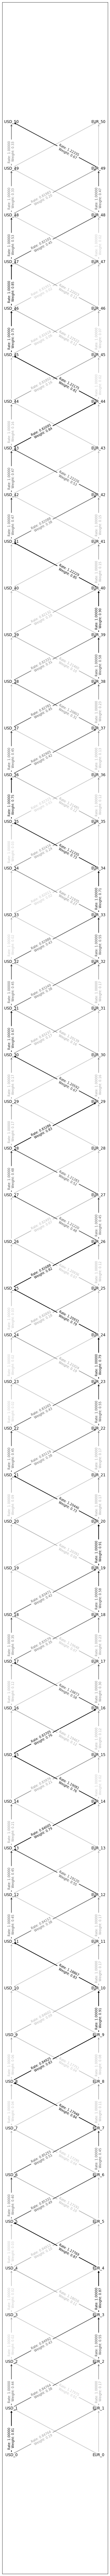

In [15]:
#calculate the costs for your network
fx_px_1 = fx_px_pred_look1.to_numpy()
fx_dist_array = -np.log(fx_px_1.flatten())
fx_px_df = pd.DataFrame(fx_px_1, fx_px_df[-k:].index,fx_px_df[-k:].columns)
fx_graph_mtrx = fx_px_to_graph(fx_px_pred_look1, ['USD','EUR'])
#calculate the equivalence matrices
A_eq, b_eq = linprog_constraints(num_timesteps,num_curncy)
A_cvxopt, b_cvxopt, MUT = cvxopt_constraints(A_eq,b_eq)
cvxopt_fx_dist_array = cvxopt.matrix(fx_dist_array)
#measure the run-time
begin_time = time.time()
cvxopt_lp = cvxopt.solvers.lp(cvxopt_fx_dist_array,A_cvxopt,b_cvxopt, solver='glpk')
cvxopt_path = np.array(cvxopt_lp['x'])
lin_prog_test_time = time.time()-begin_time
cvxopt_result = np.dot(fx_dist_array,cvxopt_path)
print("CVXOPT Test: 1 In, {out} Out. Used time: {used_time}".format(
    out = np.exp(-cvxopt_result[0]), used_time = lin_prog_test_time))
weight_mtrx_cvxopt = pd.DataFrame(cvxopt_path.reshape((num_timesteps,num_curncy**2)), index = fx_px_df.index, columns = fx_px_df.columns)
weight_mtrx_cvxopt = fx_px_to_graph(weight_mtrx_cvxopt, curncy_list)

# Plots the problem in directed graph with the optimal solution
plot_fx_digraph(fx_graph_mtrx, weight_mtrx_cvxopt, num_curncy, num_timesteps)

CVXOPT Test: 1 In, 1.0433381037918878 Out. Used time: 0.006345033645629883


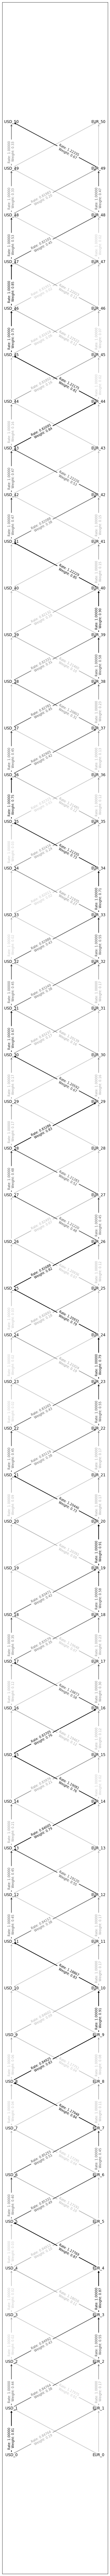

In [16]:
#calculate the costs for your network
fx_dist_array = -np.log(fx_px[-k:,:].flatten())
fx_px_df = pd.DataFrame(fx_px[-k:,:], fx_px_df[-k:].index,fx_px_df.columns)
fx_px_graph_mtrx = fx_px_to_graph(fx_px_df[-k:][:], ['USD','EUR'])
#calculate the equivalence matrices
A_eq, b_eq = linprog_constraints(num_timesteps,num_curncy)
A_cvxopt, b_cvxopt, MUT = cvxopt_constraints(A_eq,b_eq)
cvxopt_fx_dist_array = cvxopt.matrix(fx_dist_array)
#measure the run-time
begin_time = time.time()
cvxopt_lp = cvxopt.solvers.lp(cvxopt_fx_dist_array,A_cvxopt,b_cvxopt, solver='glpk')
cvxopt_path = np.array(cvxopt_lp['x'])
lin_prog_test_time = time.time()-begin_time
cvxopt_result = np.dot(fx_dist_array,cvxopt_path)
print("CVXOPT Test: 1 In, {out} Out. Used time: {used_time}".format(
    out = np.exp(-cvxopt_result[0]), used_time = lin_prog_test_time))
#weight_mtrx_cvxopt = pd.DataFrame(cvxopt_path.reshape((num_timesteps,num_curncy**2)), index = fx_px_df.index, columns = fx_px_df.columns)
#weight_mtrx_cvxopt = fx_px_to_graph(weight_mtrx_cvxopt, curncy_list)

# Plots the problem in directed graph with the optimal solution
plot_fx_digraph(fx_graph_mtrx, weight_mtrx_cvxopt, num_curncy, num_timesteps)

## Noisy system
In this part of the project, we introduce the noise to the data. The goal is to predict future market conditions hence we need to add some noise to include the prediction error from the controller. 

In [ ]:
pure = fx_px
dim_x = pure.shape[0]
dim_y = pure.shape[1] 
noise_np = np.zeros((dim_x, dim_y))
for t in range(0,num_timesteps):
    exp_noise_t = 0.2*t
    noise_np[t,:]=np.random.normal(exp_noise_t,0.01,(1,dim_y))
signal = pure + noise_np

## Linear programming solution of the noisy system weights

In [ ]:
import random
# Preparations for CVXOPT
#calculate the costs for your network
fx_dist_array = -np.log(signal.flatten())
signal_df = pd.DataFrame(signal, fx_px_df.index,fx_px_df.columns)
signal_graph_mtrx = fx_px_to_graph(signal_df, ['USD','EUR'])
#calculate the equivalence matrices
A_eq, b_eq = linprog_constraints(num_timesteps,num_curncy)
A_cvxopt, b_cvxopt, MUT = cvxopt_constraints(A_eq,b_eq)
cvxopt_fx_dist_array = cvxopt.matrix(fx_dist_array)
#measure the run-time
begin_time = time.time()
cvxopt_lp = cvxopt.solvers.lp(cvxopt_fx_dist_array,A_cvxopt,b_cvxopt, solver='glpk')
cvxopt_path = np.array(cvxopt_lp['x'])
lin_prog_test_time = time.time()-begin_time
cvxopt_result = np.dot(fx_dist_array,cvxopt_path)
print("CVXOPT Test: 1 In, {out} Out. Used time: {used_time}".format(
    out = np.exp(-cvxopt_result[0]), used_time = lin_prog_test_time))
weight_mtrx_cvxopt = pd.DataFrame(cvxopt_path.reshape((num_timesteps,num_curncy**2)), index = fx_px_df.index, columns = fx_px_df.columns)
weight_mtrx_cvxopt = fx_px_to_graph(weight_mtrx_cvxopt, curncy_list)

# Plots the problem in directed graph with the optimal solution
#plot_fx_digraph(fx_graph_mtrx, weight_mtrx_cvxopt, num_curncy, num_timesteps)
plot_fx_digraph(signal_graph_mtrx, weight_mtrx_cvxopt, num_curncy, num_timesteps)

In [ ]:
# A sample tutorial problem with custom rates
begin_time = time.time()

# This form of df is previously defined. Copied here:
# For instance, if curncy_list = ['USD', 'EUR'], then the column names of fx_px_df should be ['USD_USD', 'USD_EUR', 'EUR_USD', 'EUR_EUR'].
test_px = np.array([[10,1,10,1,1,1,1,1,1],[10,1,1,1,1,1,1,1,10],[10,1,1,1,1,1,10,1,1]])
test_px_df = pd.DataFrame(test_px, columns=['Test1_Test1','Test1_Test2','Test1_Test3','Test2_Test1','Test2_Test2','Test2_Test3','Test3_Test1','Test3_Test2','Test3_Test3'],
                          index=['Step1','Step2','Step3'])
test_px_graph_mtrx = fx_px_to_graph(test_px_df, ['Test1', 'Test2', 'Test3'])

# Preparations for CVXOPT
test_dist_array = -np.log(test_px.flatten())
A_eq, b_eq = linprog_constraints(3,3)
A_cvxopt, b_cvxopt,mut = cvxopt_constraints(A_eq,b_eq)
cvxopt_test_dist_array = cvxopt.matrix(test_dist_array)

#CVXOPT: A case when two paths could exist using cvxopt's default solver. (Not as good I think as glpk)
begin_time = time.time()
cvxopt_lp = cvxopt.solvers.lp(cvxopt_test_dist_array,A_cvxopt,b_cvxopt)
cvxopt_path = np.array(cvxopt_lp['x'])
#cvxopt_result = np.dot(test_dist_array,cvxopt_path)
cvxopt_time = time.time() - begin_time
weight_mtrx_cvxopt = pd.DataFrame(cvxopt_path.reshape((3,3**2)), index = test_px_df.index, columns = test_px_df.columns)
weight_mtrx_cvxopt = fx_px_to_graph(weight_mtrx_cvxopt, ['Test1', 'Test2', 'Test3'])

# Plots the problem in directed graph with the optimal solution
plot_fx_digraph(test_px_graph_mtrx, weight_mtrx_cvxopt, 3, 3)
 

In [ ]:
fx_px_df.head()

## Ford Fulkerson Algorithm


In [ ]:
## import networkx as nx
begin_time = time.time()
# create the direct graph using networkx package
G = nx.DiGraph()
G.add_node("s", demand=-1)
G.add_node("t", demand=1)
G.add_edge("s", "usd1", weight=1, capacity=0.92632099)
G.add_edge("s", "eur1", weight=1.17148, capacity=0.9239593)
G.add_edge("usd1", "t", weight=1, capacity=0.85818732)
G.add_edge("eur1", "t", weight=0.853228, capacity=0.46892327)
flowDict = nx.min_cost_flow(G)
ff_test_time = time.time() - begin_time


In [ ]:
flowDict

In [ ]:
ff_test_time

# Custom example for 2x2
Currencies Test1 and Test2. Test 1 is the source and sink currency. 2 days

In [ ]:
# A sample tutorial problem with custom rates
begin_time = time.time()

# This form of df is previously defined. Copied here:
# For instance, if curncy_list = ['USD', 'EUR'], then the column names of fx_px_df should be ['USD_USD', 'USD_EUR', 'EUR_USD', 'EUR_EUR'].
test_px = np.array([[10,1,1,10],[10,1,1,10]])
test_px_df = pd.DataFrame(test_px, columns=['Test1_Test1','Test1_Test2','Test2_Test1','Test2_Test2'],
                          index=['Step1','Step2'])
test_px_graph_mtrx = fx_px_to_graph(test_px_df, ['Test1', 'Test2'])

# Preparations for CVXOPT
test_dist_array = -np.log(test_px.flatten())
A_eq, b_eq = linprog_constraints(2,2)
A_cvxopt, b_cvxopt,mut = cvxopt_constraints(A_eq,b_eq)
cvxopt_test_dist_array = cvxopt.matrix(test_dist_array)

#CVXOPT: A case when two paths could exist using cvxopt's default solver. (Not as good I think as glpk)
begin_time = time.time()
cvxopt_lp = cvxopt.solvers.lp(cvxopt_test_dist_array,A_cvxopt,b_cvxopt)
cvxopt_path = np.array(cvxopt_lp['x'])
#cvxopt_result = np.dot(test_dist_array,cvxopt_path)
cvxopt_time = time.time() - begin_time
weight_mtrx_cvxopt = pd.DataFrame(cvxopt_path.reshape((2,2**2)), index = test_px_df.index, columns = test_px_df.columns)
weight_mtrx_cvxopt = fx_px_to_graph(weight_mtrx_cvxopt, ['Test1', 'Test2'])

# Plots the problem in directed graph with the optimal solution
plot_fx_digraph(test_px_graph_mtrx, weight_mtrx_cvxopt, 2, 2)
 

In [ ]:
simple_mut = np.array([0.9,0.5,1,1,1,1,1,1])

In [ ]:
G = nx.bipartite.gnmk_random_graph(3, 5, 10, seed=123)
top = nx.bipartite.sets(G)[0]
pos = nx.bipartite_layout(G, top)


In [ ]:
plot_system(test_px_graph_mtrx, 2, 2)

## Prediction model for currency pairs
Autoregressive prediction model for time-series data. Autoregressive model uses past data to predict the new data from the model.

In [ ]:
fx_px_df.plot()

In [ ]:
fx_px_df

In [ ]:
from pandas.plotting import lag_plot
lag_plot(fx_px_df)